Importy

In [49]:
import warnings
warnings.filterwarnings("ignore")

In [50]:
import pandas as pd
import numpy as np

import isodate

import re
import string

from collections import Counter
from wordcloud import WordCloud

from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#### Hipotezy
<ul>
<li> Najpopularniejsze są filmy o charakterze podróżniczym (EDA) </li>
<li> Da się pogrupować filmy tematycznie na podstawie transkrypcji (Grupowanie) </li>
<li> Ogólny wskaźnik sentymentu dla kategorii dotyczących wiadomości i polityki oraz podróży jest pozytywny (analiza sentymentu) </li>
<li> * dodano w trkacie na podstawie EDA * kanaly amerykanskiej teelwizji wypowiadaja sie pozytywnie na tematy zwiazane z Polska (analiza sentymentu) </li>
</ul>

#### Dane

Dane zostały pobrane z YouTube za pomocą Youtube API.

Aby ograniczyć wyniki wyszukiwania do filmów będących przedmiotem zainteresowania (tj. o tematyce związanej z Polską, w języku angielskim, z dostępnymi napisami) użyto następujących parametrów wyszukiwania: 
<ul>
<li> q: "poland" - Zapytanie określające tematykę poszukiwanych filmów. Parametr ten działa jako kryterium wyszukiwania i wprowadza frazę, która powinna wystąpić w opisie, tytule lub metadanych filmu. W tym przypadku, fraza "Poland" jest używana do filtrowania wyników związanych z Polską,</li>
<li>type: "video" - określa, że interesujące są tylko filmy wideo,</li>
<li>videoCaption: "closedCaption" – filtruje wyniki, aby uwzględniały tylko filmy z dostępnymi napisami,</li>
<li>relevanceLanguage: "en" -  określa język filmu, którego wyszukujemy (angielski). </li>
</ul>

Do pobrania transkrypcji została wykorzystana biblioteki <code>YouTubeTranscriptApi</code> i metoda <code> get_transcript()</code> na podstawie video_id wyszukanych i pobranych we wyej wspomnianym etapie

Ostatnim etapem było wyszukanie i pobranie informacji na teamt kanału, który udostępnił dany film

# Wczytanie danych i wstępna obróbka

In [147]:
with open("data/transcriptions.txt", "r") as file:
    all_transcripts = file.read().split('|||')

all_transcripts.pop()

''

In [52]:
len(all_transcripts)

500

In [148]:
videos_details = pd.read_csv("data/videos_details.csv").drop(columns = ["Informacje o lokalizacji"])
print(videos_details.columns)
videos_details.head(10)

Index(['Tytuł', 'Data publikacji', 'Liczba wyświetleń', 'Liczba polubień',
       'Liczba komentarzy', 'Tagi filmu', 'Kategorie filmu', 'Channel_id',
       'Długość filmu', 'Rodzaj filmu', 'video_id'],
      dtype='object')


,Tytuł,Data publikacji,Liczba wyświetleń,Liczba polubień,Liczba komentarzy,Tagi filmu,Kategorie filmu,Channel_id,Długość filmu,Rodzaj filmu,video_id
0,Getting Past Polish Immigration,2023-11-09T08:00:31Z,299271,18467,1173,"['Foil Arms and Hog', 'sketch comedy', 'comedy...",23,UCzb-6smlTg5UPirLdsdQ_cQ,PT2M2S,hd,flwcUmS_8Ws
1,Could Poland Become The Next Germany? | Econom...,2023-10-08T15:05:13Z,461061,12698,1939,"['economics', 'economics explained', 'economy ...",27,UCZ4AMrDcNrfy3X6nsU8-rPg,PT19M17S,hd,p9Tnjr3Lluk
2,How Poland is Becoming Europe's Next Military ...,2023-09-10T19:15:01Z,477721,13108,1924,[],27,UCfdNM3NAhaBOXCafH7krzrA,PT27M2S,hd,pEeAAyIFf8Y
3,Could the Russian Military Conquer Poland on I...,2023-10-31T22:00:11Z,357857,4706,1368,"['us', 'military', 'us military', 'us navy', '...",28,UCKfak8fBm_Lhy4eX9UKxEpA,PT19M51S,hd,H-KH0vls1zU
4,Poland's Path to Becoming the Next Advanced Ec...,2023-10-20T11:52:27Z,189518,3857,1118,"['economy of poland', 'poland economics explai...",27,UCyHJ94JzwY92NsBVzJ2aE3Q,PT12M46S,hd,gzbtAJ7x_mg
5,How Poland is Becoming Europe's Next Military ...,2023-10-02T21:30:10Z,133397,3470,823,"['us', 'military', 'us military', 'us navy', '...",28,UCKfak8fBm_Lhy4eX9UKxEpA,PT20M20S,hd,sbgDxfohCFY
6,Polish Independence Day | KRAKÓW | 11 Listopad...,2023-11-11T22:27:24Z,78272,2285,224,"['Poland Independence Day', 'Polish Independen...",19,UCL9QCO5vimeOw2VLh3xdWQw,PT29M34S,hd,1wd4PWX1kng
7,Is Gdańsk the MOST BEAUTIFUL City in Poland?! ...,2023-09-24T13:00:17Z,51895,1546,168,"['gdansk', 'gdańsk', 'gdansk travel', 'Gdansk ...",19,UCd1DAfDaPdUbQQhqcQKfQJw,PT21M5S,hd,HuF6Qe2WJlU
8,CO IZRAELCZYCY MYŚLĄ O POLSCE I POLAKACH? 2 so...,2023-06-24T12:00:07Z,30377,935,686,"['UBA', 'Izrael', 'Polska', 'historia', 'Sonda...",19,UCVuGm5jBEnfmytM5zT8jGBg,PT10M40S,hd,uBO0ITtbj1Q
9,Amazing Places to visit in Poland | Best Place...,2021-06-09T21:02:25Z,1528936,30948,1723,"['best places', 'places', 'travel video', 'ama...",19,UCy_b-3y4ua9H5GPwIosu0OA,PT10M50S,hd,-88MfJr4-dg


In [ ]:
channel_details = pd.read_csv("data/channel_details.csv")
print(channel_details.columns)
channel_details

Index(['Tytuł kanału', 'Kraj', 'Liczba subskrybentów', 'Channel_id'], dtype='object')


,Tytuł kanału,Kraj,Liczba subskrybentów,Channel_id
0,Foil Arms and Hog,IE,923000,UCzb-6smlTg5UPirLdsdQ_cQ
1,Economics Explained,US,2390000,UCZ4AMrDcNrfy3X6nsU8-rPg
2,The Infographics Show,US,13600000,UCfdNM3NAhaBOXCafH7krzrA
3,The Military Show,US,664000,UCKfak8fBm_Lhy4eX9UKxEpA
4,Econ,IN,91600,UCyHJ94JzwY92NsBVzJ2aE3Q
...,...,...,...,...
495,4K Relaxing City Walks,GB,1770,UCfU2X_rOIXA-t0A8KgwmHOQ
496,Rounded Kids,GB,1010,UCcC5AasdcqtvR2aNCBKUQsA
497,THE CURIOSITY CORNER,US,589,UCCcycw_uukrBthI89-pyA9Q
498,Kobieta 70plus,PL,172,UCYGbwQ6eBcmsXJ3_O6yolug


### Połączenie danych

In [55]:
data = videos_details
data["Nazwa kanalu"] = channel_details["Tytuł kanału"]
data["Kraj kanału"] = channel_details["Kraj"]
data["Subskrypcje"] = channel_details["Liczba subskrybentów"]
data['Transkrypcja'] = all_transcripts
data

,Tytuł,Data publikacji,Liczba wyświetleń,Liczba polubień,Liczba komentarzy,Tagi filmu,Kategorie filmu,Channel_id,Długość filmu,Rodzaj filmu,video_id,Nazwa kanalu,Kraj kanału,Subskrypcje,Transkrypcja
0,Getting Past Polish Immigration,2023-11-09T08:00:31Z,299271,18467,1173,"['Foil Arms and Hog', 'sketch comedy', 'comedy...",23,UCzb-6smlTg5UPirLdsdQ_cQ,PT2M2S,hd,flwcUmS_8Ws,Foil Arms and Hog,IE,923000,Good morning Before granting you entry to Pola...
1,Could Poland Become The Next Germany? | Econom...,2023-10-08T15:05:13Z,461061,12698,1939,"['economics', 'economics explained', 'economy ...",27,UCZ4AMrDcNrfy3X6nsU8-rPg,PT19M17S,hd,p9Tnjr3Lluk,Economics Explained,US,2390000,this video is sponsored by hubsports this is P...
2,How Poland is Becoming Europe's Next Military ...,2023-09-10T19:15:01Z,477721,13108,1924,[],27,UCfdNM3NAhaBOXCafH7krzrA,PT27M2S,hd,pEeAAyIFf8Y,The Infographics Show,US,13600000,After the devastation it suffered in World\nWa...
3,Could the Russian Military Conquer Poland on I...,2023-10-31T22:00:11Z,357857,4706,1368,"['us', 'military', 'us military', 'us navy', '...",28,UCKfak8fBm_Lhy4eX9UKxEpA,PT19M51S,hd,H-KH0vls1zU,The Military Show,US,664000,Poland is becoming an intimidating military\nf...
4,Poland's Path to Becoming the Next Advanced Ec...,2023-10-20T11:52:27Z,189518,3857,1118,"['economy of poland', 'poland economics explai...",27,UCyHJ94JzwY92NsBVzJ2aE3Q,PT12M46S,hd,gzbtAJ7x_mg,Econ,IN,91600,"This number, 226, is the percentage increase\n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,"""SEA EYE"" ZAKOPANE POLAND DECEMBER 2022 ❄ AMAZ...",2022-12-21T11:50:22Z,247,10,3,"['SEA EYE', 'ZAKOPANE', 'ZAKOPANE POLAND', 'ZA...",19,UCfU2X_rOIXA-t0A8KgwmHOQ,PT21S,hd,PS-EZLpH6uI,4K Relaxing City Walks,GB,1770,"winter in zakopane, poland december 2022, chri..."
496,Poland explained in 60 seconds!🇵🇱 #geography #...,2022-03-03T23:54:50Z,12770,496,23,[],27,UCcC5AasdcqtvR2aNCBKUQsA,PT1M,hd,5JFYZvpz1AE,Rounded Kids,GB,1010,hello and welcome back to borders today we're ...
497,Countries as Super Heroes!🦸🦹PART 2! AI FUN #ai...,2023-01-16T22:45:00Z,1694,55,3,"['ai', 'funfacts', 'usa', 'poland', 'brazil', ...",28,UCCcycw_uukrBthI89-pyA9Q,PT22S,hd,HPOF0uCwLwU,THE CURIOSITY CORNER,US,589,countries as superheroes part two AI generated...
498,"Poland. GDYNIA. Naval Port, Nawal Shipyard Por...",2023-11-01T09:00:06Z,820,17,0,[],19,UCYGbwQ6eBcmsXJ3_O6yolug,PT8M26S,hd,7I5DTvTUX40,Kobieta 70plus,PL,172,Brak dostępnych napisów dla tego filmu.


### Usunięcie duplikatów i filmów z niedostępnymi napisami

In [56]:
data = data.drop_duplicates()
len(data)

477

In [57]:
data = data[data["Transkrypcja"] != "Brak dostępnych napisów dla tego filmu."]
len(data)

418

In [58]:
data = data[data["Transkrypcja"] != " "]
len(data)

416

Okazuje się, ze zakradło się transkrypcję w innych językach niz angielski, ktore trzeba usunąć:

In [59]:
print(data.loc[[441, 328, 94, 374, 445], "Transkrypcja"])

441    Czy w Polsce da się powiedzieć... nie w Polsce...
328    Привіт, хлопці! Як ви? Добре! З відки ви? З Ін...
94     Na południu Polski, poza miejscem, gdzie równi...
374    Hejka! Co tam Właśnie przygotowuję się do… wyj...
445    Wszyscy cenimy swój czas, dlatego szukamy najl...
Name: Transkrypcja, dtype: object


Ponadto jeden tekst jest mocno zaburzony a wiec rowniez zostanie usuniety:

In [60]:
print(data.loc[349, "Transkrypcja"])

yo bois See me? No? let START Ooooo boiieeeeeeee Gotta go f a s t o hei wanna-- Agh 𝗔𝗪𝗘𝗦𝗢𝗠𝗘 𝘽𝙖𝙣𝙂𝘽𝙣𝙖𝙂𝙣𝙗𝘼𝙣 rip paganism statues scary *getting some territories* ded 🎱 *drop* *crown appear* :O ᴅᴀᴛ ʙᴇᴀᴜᴛɪғᴜʟ :3 Uhh...? █▀▀ █░░ █▀▀█ █▀▀█
▀▀█ █░░ █▄▄█ █░░█
▀▀▀ ▀▀▀ ▀░░▀ █▀▀▀ 🅰️*suprised* HA HA HA HA H∀ S H U T  U P 𝕜𝕟𝕚𝕗𝕖 𝕚𝕟 𝕜𝕟𝕚𝕗𝕖 𝕠𝕦𝕥 eXistential cries *cough* 𝘙𝘶𝘜𝘜𝘶𝘜𝘶𝘮 wtf rook? oh Yes :o ∀∀∀∀∀∀∀∀∀ 1 ÷ 7 🎱 🎱 🎱 You want something betch? O k ǝ ǝ ǝ [thinking] ʷᵃᶦᵗ Wʰᵃ ? *plum* ᗪYIᑎG ᑕᑌTEᒪY [hungry Teutonic Order appaer] 0h its only butter knife *But its too much to day* 🅰️ [magnification with a microscope, u can see atoms now] r^{2}={\frac {b^{2}}{1-e^{2}\cos ^{2}\theta }}={\frac {a^{2}b^{2}}{a^{2}sin^{2}\theta +b^{2}cos^{2}\theta }},} O ʙᴏɪ Y A O O 𝘙 𝘶 𝘯    𝘯 𝘰 𝘸 [expanding territories] What is wrong with YUUUuu just St00*8P hammer pain ded take some lands put Oh BO̵̖̤͕͉͙̮̔̃̍̿͝Ĩ́ͩͧ̈́̓ͪ͌͆ͪ̑ͮ͒͋́ͬ
ͮ̐ͤ̿̀̃ͣͭ͐ͧ̏ͩ̿͋ͫ
͇̤͍̹͇͇ͅ Freinds? want union? 🆗 Lithuania get christianization O LES GOooOo Teutonic.mp

Na samym koncu analizy znaleziono kolejne języki nie będące angielskim (wedlug google tlumacz jest to 'sepedi' i 'ilokański' ale jest to chyba tylko błąd w pobraniu):

In [61]:
data.loc[206]

Tytuł                Rockets or missiles reported to have landed in...
Data publikacji                                   2022-11-15T21:47:53Z
Liczba wyświetleń                                               820857
Liczba polubień                                                   7747
Liczba komentarzy                                                 5649
Tagi filmu           ['Rockets', 'missiles', 'landed', 'Poland', 'n...
Kategorie filmu                                                     25
Channel_id                                    UCupvZG-5ko_eiXAupbDfxWw
Długość filmu                                                    PT11M
Rodzaj filmu                                                        hd
video_id                                                   -0SAFfGzm-8
Nazwa kanalu                                                       CNN
Kraj kanału                                        Brak danych o kraju
Subskrypcje                                                   15800000
Transk

In [62]:
data.loc[30]

Tytuł                Retired colonel explains why Wagner's move tow...
Data publikacji                                   2023-07-29T21:38:30Z
Liczba wyświetleń                                               480378
Liczba polubień                                                   4650
Liczba komentarzy                                                 1711
Tagi filmu           ['Cedric Leighton', 'Russia', 'Ukraine', 'Wagn...
Kategorie filmu                                                     25
Channel_id                                    UCupvZG-5ko_eiXAupbDfxWw
Długość filmu                                                   PT2M6S
Rodzaj filmu                                                        hd
video_id                                                   XZCTrcOITW4
Nazwa kanalu                                                       CNN
Kraj kanału                                        Brak danych o kraju
Subskrypcje                                                   15800000
Transk

Jedna transkrypcja została źle pobrana (ucięta), uznaje tą pozycje za brak danych o transkrypcji, które są usuwane

In [63]:
print(data.loc[382]["Transkrypcja"])

GOD-HONOR-THE HOMELAND Presents The film promoting Poland. POLISH NATIONAL ANTHEM MATERIALS USED Music:  


In [64]:
data = data.drop([441, 328, 94, 374, 445, 349, 206, 382, 206, 30])

In [65]:
data.shape

(407, 15)

### Przekształcenie danych

In [66]:
data["Długość filmu"] = data["Długość filmu"].apply(lambda x: round(isodate.parse_duration(x).total_seconds() // 60))

In [67]:
data.head()

,Tytuł,Data publikacji,Liczba wyświetleń,Liczba polubień,Liczba komentarzy,Tagi filmu,Kategorie filmu,Channel_id,Długość filmu,Rodzaj filmu,video_id,Nazwa kanalu,Kraj kanału,Subskrypcje,Transkrypcja
0,Getting Past Polish Immigration,2023-11-09T08:00:31Z,299271,18467,1173,"['Foil Arms and Hog', 'sketch comedy', 'comedy...",23,UCzb-6smlTg5UPirLdsdQ_cQ,2,hd,flwcUmS_8Ws,Foil Arms and Hog,IE,923000,Good morning Before granting you entry to Pola...
1,Could Poland Become The Next Germany? | Econom...,2023-10-08T15:05:13Z,461061,12698,1939,"['economics', 'economics explained', 'economy ...",27,UCZ4AMrDcNrfy3X6nsU8-rPg,19,hd,p9Tnjr3Lluk,Economics Explained,US,2390000,this video is sponsored by hubsports this is P...
2,How Poland is Becoming Europe's Next Military ...,2023-09-10T19:15:01Z,477721,13108,1924,[],27,UCfdNM3NAhaBOXCafH7krzrA,27,hd,pEeAAyIFf8Y,The Infographics Show,US,13600000,After the devastation it suffered in World\nWa...
3,Could the Russian Military Conquer Poland on I...,2023-10-31T22:00:11Z,357857,4706,1368,"['us', 'military', 'us military', 'us navy', '...",28,UCKfak8fBm_Lhy4eX9UKxEpA,19,hd,H-KH0vls1zU,The Military Show,US,664000,Poland is becoming an intimidating military\nf...
4,Poland's Path to Becoming the Next Advanced Ec...,2023-10-20T11:52:27Z,189518,3857,1118,"['economy of poland', 'poland economics explai...",27,UCyHJ94JzwY92NsBVzJ2aE3Q,12,hd,gzbtAJ7x_mg,Econ,IN,91600,"This number, 226, is the percentage increase\n..."


Nadanie wartości tekstowych kategoriom:

https://mixedanalytics.com/blog/list-of-youtube-video-category-ids/

In [68]:
mapping_cat_dict = {
    19: 'Travel & Events',
    27: 'Education',
    25: 'News & Politics',
    22: 'People & Blogs',
    24: 'Entertainment',
    28: 'Science & Technology',
    20: 'Gaming',
    10: 'Music',
    1: 'Film & Animation',
    23: 'Comedy',
    26: 'Howto & Style',
    15: 'Pets & Animals',
    29: 'Nonprofits & Activism',
    2: 'Autos & Vehicles'
}

data_cat = data.copy()
data_cat["Kategorie filmu"] = data_cat["Kategorie filmu"].replace(mapping_cat_dict)
data_cat.head()

,Tytuł,Data publikacji,Liczba wyświetleń,Liczba polubień,Liczba komentarzy,Tagi filmu,Kategorie filmu,Channel_id,Długość filmu,Rodzaj filmu,video_id,Nazwa kanalu,Kraj kanału,Subskrypcje,Transkrypcja
0,Getting Past Polish Immigration,2023-11-09T08:00:31Z,299271,18467,1173,"['Foil Arms and Hog', 'sketch comedy', 'comedy...",Comedy,UCzb-6smlTg5UPirLdsdQ_cQ,2,hd,flwcUmS_8Ws,Foil Arms and Hog,IE,923000,Good morning Before granting you entry to Pola...
1,Could Poland Become The Next Germany? | Econom...,2023-10-08T15:05:13Z,461061,12698,1939,"['economics', 'economics explained', 'economy ...",Education,UCZ4AMrDcNrfy3X6nsU8-rPg,19,hd,p9Tnjr3Lluk,Economics Explained,US,2390000,this video is sponsored by hubsports this is P...
2,How Poland is Becoming Europe's Next Military ...,2023-09-10T19:15:01Z,477721,13108,1924,[],Education,UCfdNM3NAhaBOXCafH7krzrA,27,hd,pEeAAyIFf8Y,The Infographics Show,US,13600000,After the devastation it suffered in World\nWa...
3,Could the Russian Military Conquer Poland on I...,2023-10-31T22:00:11Z,357857,4706,1368,"['us', 'military', 'us military', 'us navy', '...",Science & Technology,UCKfak8fBm_Lhy4eX9UKxEpA,19,hd,H-KH0vls1zU,The Military Show,US,664000,Poland is becoming an intimidating military\nf...
4,Poland's Path to Becoming the Next Advanced Ec...,2023-10-20T11:52:27Z,189518,3857,1118,"['economy of poland', 'poland economics explai...",Education,UCyHJ94JzwY92NsBVzJ2aE3Q,12,hd,gzbtAJ7x_mg,Econ,IN,91600,"This number, 226, is the percentage increase\n..."


In [69]:
data_cat["Kategorie filmu"].value_counts()

Kategorie filmu
Travel & Events          101
News & Politics           79
Education                 62
People & Blogs            60
Entertainment             33
Music                     16
Science & Technology      14
Film & Animation           9
Comedy                     8
Nonprofits & Activism      7
Autos & Vehicles           7
Gaming                     6
Howto & Style              4
Pets & Animals             1
Name: count, dtype: int64

Wszytskie wartości przypisane poprawnie

<hr>

# EDA

In [70]:
data.describe()

,Liczba wyświetleń,Liczba polubień,Liczba komentarzy,Kategorie filmu,Długość filmu,Subskrypcje
count,4.070000e+02,407.000000,407.000000,407.000000,407.000000,4.070000e+02
mean,3.474133e+05,8141.552826,1125.122850,21.820639,10.734644,1.393233e+06
std,1.155180e+06,21296.557572,3590.194997,5.735102,11.728176,3.411072e+06
min,3.500000e+01,0.000000,0.000000,1.000000,0.000000,2.100000e+01
25%,3.252000e+03,91.500000,12.500000,19.000000,3.000000,3.780000e+03
50%,2.412300e+04,651.000000,101.000000,23.000000,8.000000,6.960000e+04
75%,1.882585e+05,4731.000000,765.500000,25.000000,14.000000,7.325000e+05
max,1.827064e+07,167483.000000,43480.000000,29.000000,103.000000,1.940000e+07


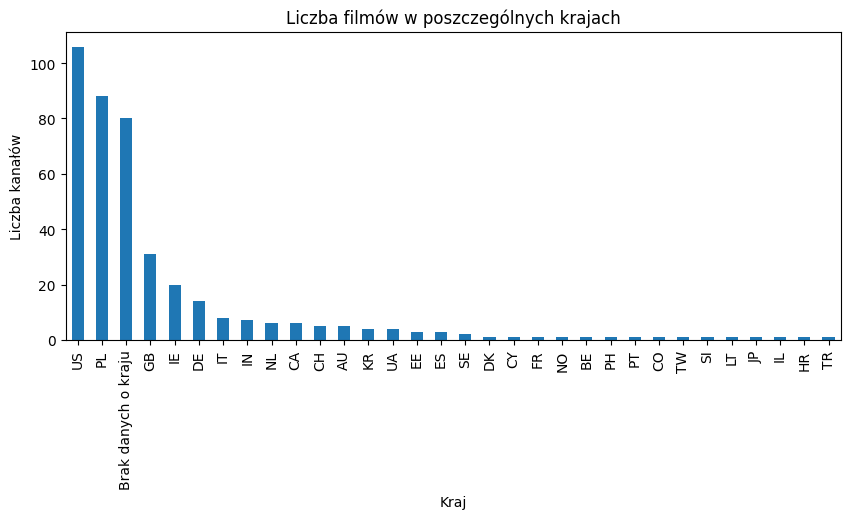

In [71]:
plt.figure(figsize=(10, 4))  
data['Kraj kanału'].value_counts().plot(kind='bar')
plt.title('Liczba filmów w poszczególnych krajach')
plt.xlabel('Kraj')
plt.ylabel('Liczba kanałów')
plt.show()

Najwięcej filmów w zebranej bazie pochodzi z USA (US - 107 filmów), następnie z Polski (PL - 91 filmów). Aż 83 filmów nie zawiera informacji o kraju pochodzenia kanału, który go udostępnił. Trzecim największym dostawcą filmów o Polsce w bazie na podstawie dostępnych informacji jest Wielka Brytania (GB – 32 filmów). Kolejno wyróżniającymi się krajami są: Irlandia (IE – 20 filmów) oraz Niemcy (DE – 14 filmów).

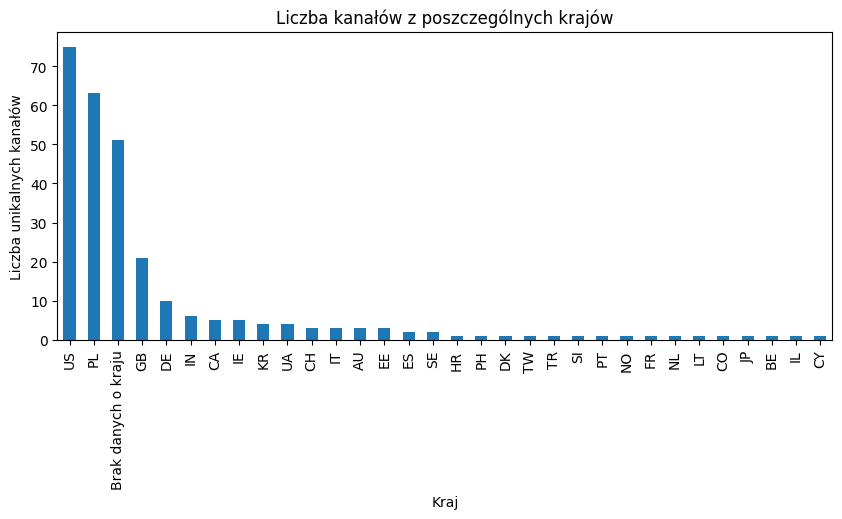

In [72]:
channel_counts = data.groupby('Kraj kanału')['Nazwa kanalu'].nunique()

channel_counts_sorted = channel_counts.sort_values(ascending=False)

plt.figure(figsize=(10, 4))
channel_counts_sorted.plot(kind='bar')
plt.title('Liczba kanałów z poszczególnych krajów')
plt.xlabel('Kraj')
plt.ylabel('Liczba unikalnych kanałów')

plt.show()

Pierwsze trzy pozycje w rankingu krajów, z których pochodzi najwięcej kanałów pozostaje bez zmian w porównaniu do liczby filmów z poszczególnych krajów (nie uwzględniając „Brak danych o kraju”). Stany zjednoczone (US) z wynikiem 75 kanałów, Polska (PL) z wynikiem 63 kanałów oraz Wielka Brytania (GB) z wynikiem 21 kanałów W dalszej części następują małe zmiany, m.in. 4 pod względem liczebności kanałów w bazie są Niemcy (DE - 10 kanałów), a Irlandia która zajmowała to miejsce w poprzednim rankingu teraz jest siódma (IE – 7 kanałów).

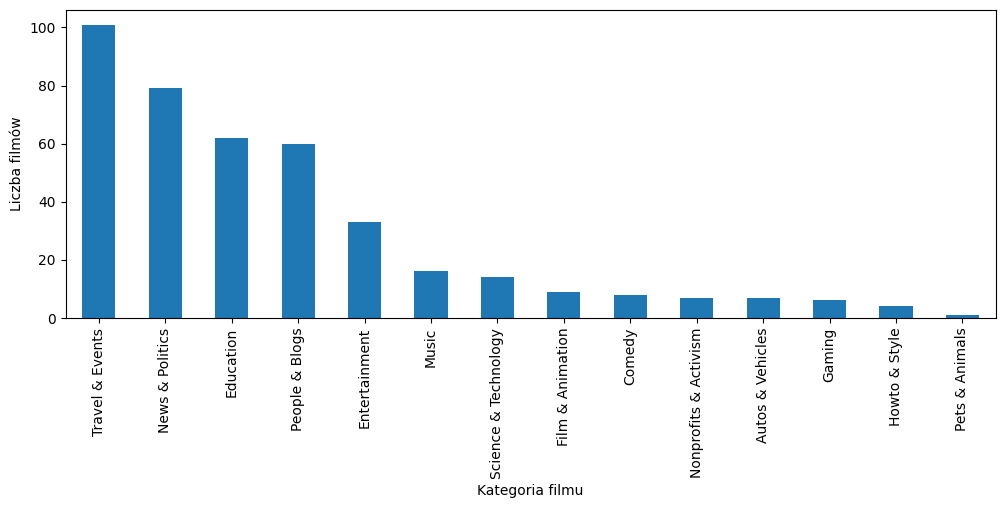

In [73]:
plt.figure(figsize=(12, 4))
data_cat['Kategorie filmu'].value_counts().plot(kind='bar')
#plt.title('Ranking częstości występowania kategorii filmu')
plt.xlabel('Kategoria filmu')
plt.ylabel('Liczba filmów')
plt.show()

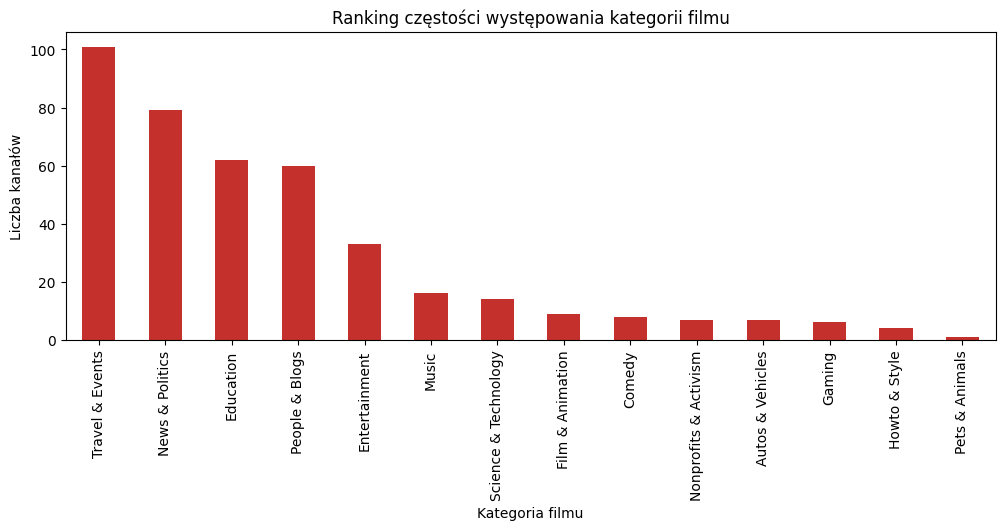

In [74]:

plt.figure(figsize=(12, 4))
data_cat['Kategorie filmu'].value_counts().plot(kind='bar', color='#c4302b')
plt.title('Ranking częstości występowania kategorii filmu')
plt.xlabel('Kategoria filmu')
plt.ylabel('Liczba kanałów')
plt.show()


In [75]:
print("Liczba filmów które nie pochodzą z polski (w tym brak danych o kraju): ",len(data_cat[data_cat["Kraj kanału"] != "PL"]))
print("Liczba filmów które nie pochodzą z Polski (bez braku danych o kraju): ", len(data_cat[(data_cat["Kraj kanału"] != "PL") & (data_cat["Kraj kanału"] != "Brak danych o kraju")]))


Liczba filmów które nie pochodzą z polski (w tym brak danych o kraju):  319
Liczba filmów które nie pochodzą z Polski (bez braku danych o kraju):  239


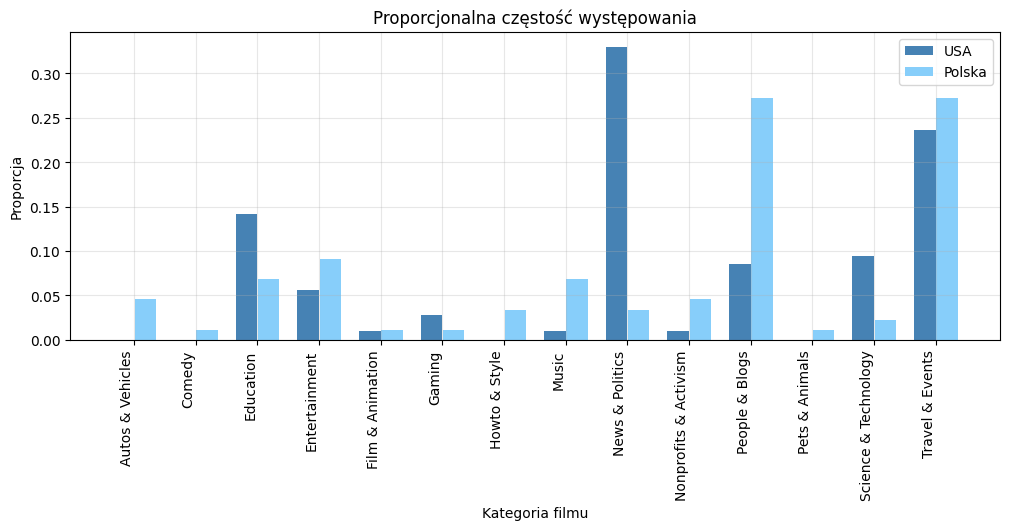

In [76]:
#USA
df_usa = data_cat[data_cat['Kraj kanału'] == 'US']
proporcje_usa = df_usa["Kategorie filmu"].value_counts(normalize=True)
df_usa_proporcje = pd.DataFrame(proporcje_usa).reset_index()
df_usa_proporcje.columns = ['Kategoria filmu', 'Proporcja']
df_usa_proporcje["Kraj kanału"] = 'US'

#PL
df_poland = data_cat[data_cat['Kraj kanału'] == 'PL']
proporcje_poland = df_poland["Kategorie filmu"].value_counts(normalize=True)
df_poland_proporcje = pd.DataFrame(proporcje_poland).reset_index()
df_poland_proporcje.columns = ['Kategoria filmu', 'Proporcja']
df_poland_proporcje["Kraj kanału"] = 'PL'

df_combined2 = pd.merge(df_usa_proporcje, df_poland_proporcje, on='Kategoria filmu', how='outer', suffixes=('_US', '_PL'))
df_combined2.loc[df_combined2["Proporcja_US"].isna(), "Proporcja_US"] = 0 #jest rozna liczbza kategorii
df_combined2.loc[df_combined2["Kraj kanału_US"].isna(), "Kraj kanału_US"] = "US" 

categories = df_combined2['Kategoria filmu']
proporcje_usa = df_combined2['Proporcja_US']
proporcje_pl = df_combined2['Proporcja_PL']

bar_positions_usa = range(len(categories))
bar_width = 0.35
bar_positions_pl = [0.36, 1.36, 2.36, 3.36, 4.36, 5.36, 6.36, 7.36, 8.36, 9.36, 10.36, 11.36, 12.36, 13.36]

plt.figure(figsize=(12, 4))
plt.bar(bar_positions_usa, proporcje_usa, width=bar_width, color='steelblue', label='USA')
plt.bar(bar_positions_pl, proporcje_pl, width=bar_width, color='lightskyblue', label='Polska')
plt.title('Proporcjonalna częstość występowania')
plt.xlabel('Kategoria filmu')
plt.ylabel('Proporcja')
plt.xticks([position + bar_width / 2 for position in bar_positions_usa], categories, rotation=90, ha='right')
plt.legend()
plt.grid(alpha =0.3)
plt.show()

Powyższy wykres przedstawia liczbę kategorii filmów proporcjonalnie do wszystkich filmów udostępnionych przez kanał w danym kraju. Można zauważyć, że najpopularniejszą kategorią nadaną na platformie YouTube dla filmów udostępnionych przez kanał w Stanach Zjednoczonych oraz związanych z tematyką Polski są wiadomości i polityka (32,7%). Co ciekawe, jest to niepopularna kategoria dla filmów przesłanych przez kanały w Polsce (3,3%), w tym przypadku najpopularniejszymi kategoriami są: ludzie i blogi (27,5%) oraz podróżowanie i wydarzenia (26,4%). Stosunkowa liczba filmów w kategorii podróżowanie i wydarzenia jest zbliżona dla obu krajów (23,4% dla USA). 

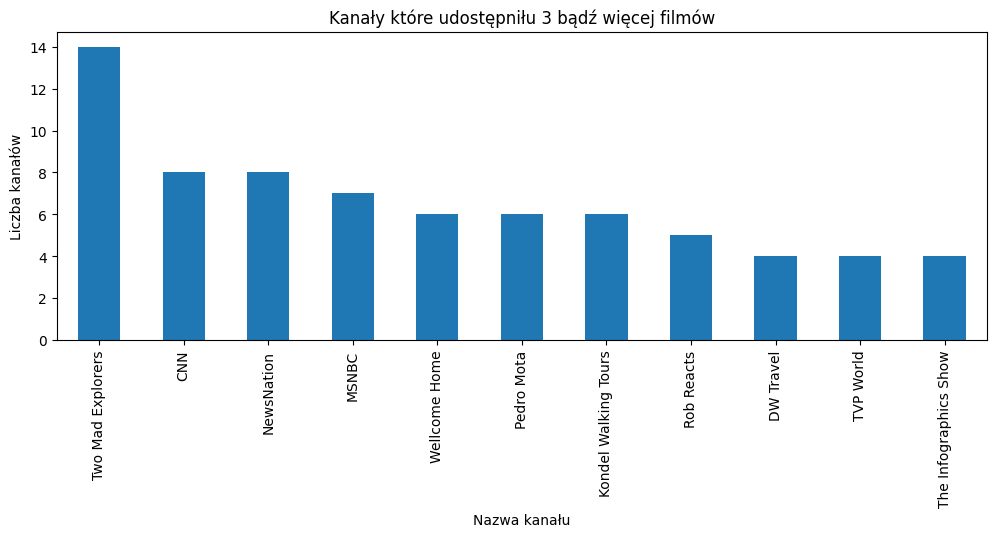

In [77]:
plt.figure(figsize=(12, 4))
data_cat['Nazwa kanalu'].value_counts().head(11).plot(kind='bar')
plt.title('Kanały które udostępniłu 3 bądź więcej filmów')
plt.xlabel('Nazwa kanału')
plt.ylabel('Liczba kanałów')
plt.show()

Można zauważyć tendencje kanałów telewizyjnych oraz podróżniczych. Może to być powiązane z popularnością kategorii, biorąc pod uwagę, że najpopularniejszymi są „Turystyka i Wydarzenia” oraz „Wiadomości i Polityka”.

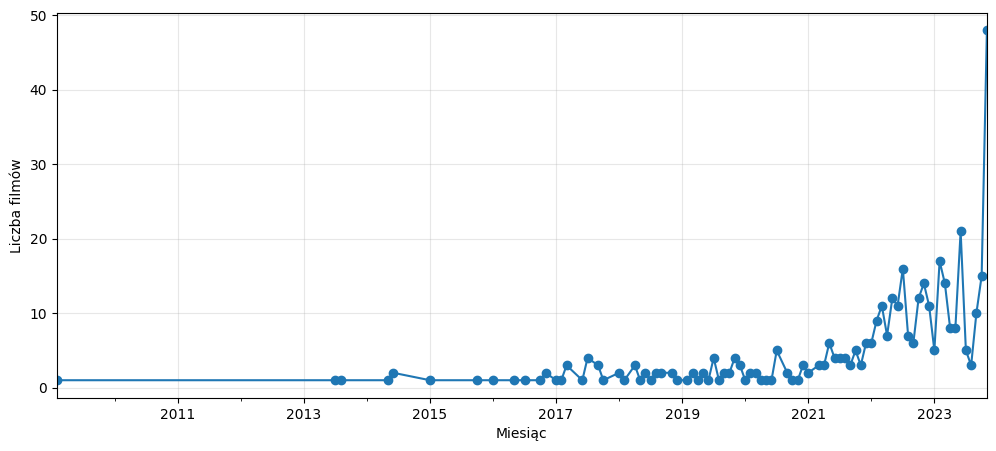

In [78]:
data_cat['Data publikacji'] = pd.to_datetime(data_cat['Data publikacji'])

monthly_counts = data_cat.groupby(data_cat['Data publikacji'].dt.to_period("M")).size()

plt.figure(figsize=(12, 5))
monthly_counts.plot(marker = 'o')
#plt.title('Liczba filmów na przestrzeni czasu (w miesiącach)')
plt.xlabel('Miesiąc')
plt.ylabel('Liczba filmów')
plt.grid(alpha = 0.3)

plt.show()

Wykres powyżej przedstawia kiedy pojawiały się filmy (kropka) oraz w jakiej ilości (oś y: „Liczba filmów”). Można zauważyć, że chronologicznie pierwszy film w bazie pochodzi 2009 roku. Pozostałe filmy zostały udostępnione od połowy 2013, jednak większą częstotliwość obserwuje się od roku 2021. Najwięcej filmów pochodzi z bieżącego roku tj. 2023.

**Popularność kategorii**

Aby wyłonić najpopularniejszą kategorie wzięto pod uwagę: liczba polubień, komentarzy oraz wyświetleń 

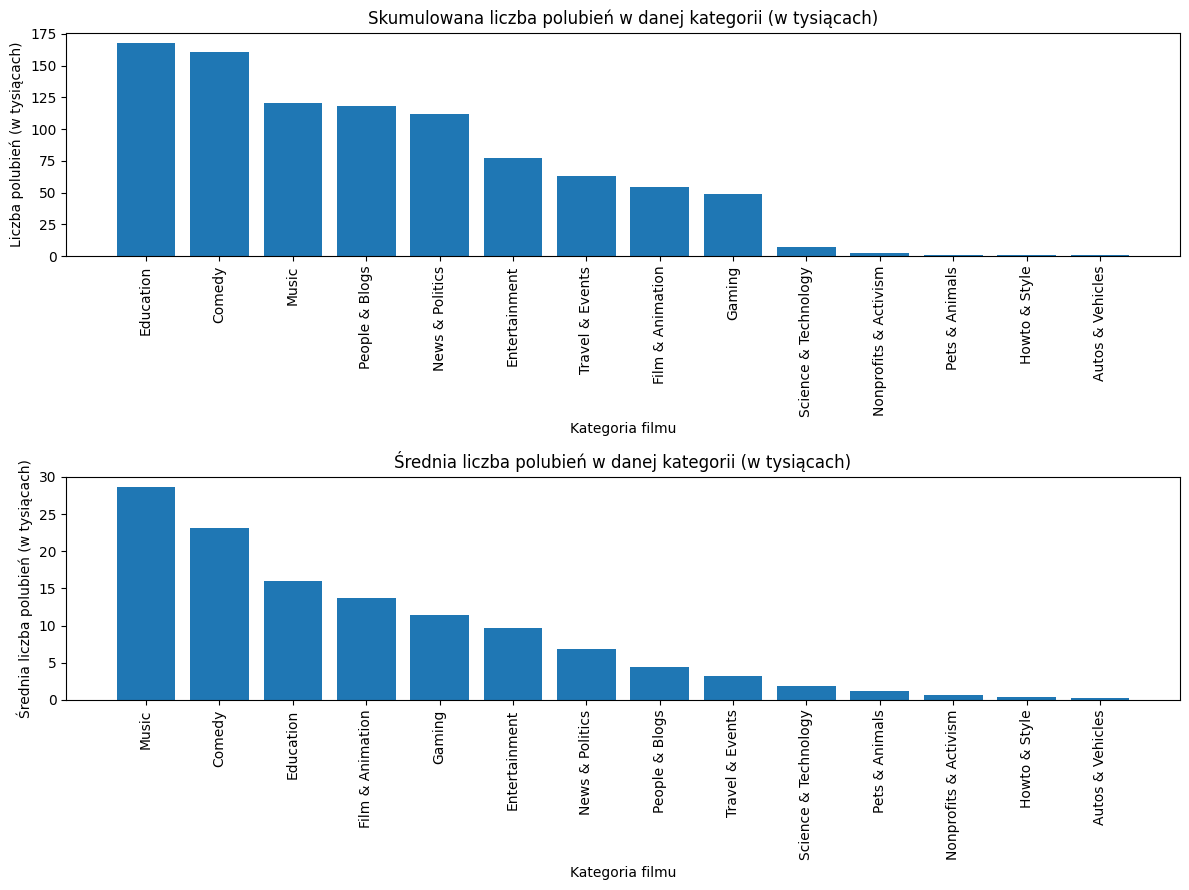

In [79]:
likes_data = data_cat.sort_values(by = "Liczba polubień", ascending= False)
likes_data["Liczba polubień w tysiącach"] = likes_data["Liczba polubień"]/1000

likes_data_mean = likes_data.groupby("Kategorie filmu")["Liczba polubień"].mean().reset_index().sort_values(by ="Liczba polubień", ascending=False)
likes_data_mean = likes_data_mean.rename(columns={"Liczba polubień": "Średnia polubień"})
likes_data_mean["Średnia polubień"] = likes_data_mean["Średnia polubień"] / 1000


plt.figure(figsize=(12, 9))

plt.subplot(2,1,1)
plt.bar(likes_data["Kategorie filmu"], likes_data["Liczba polubień w tysiącach"])
plt.title('Skumulowana liczba polubień w danej kategorii (w tysiącach)')
plt.xlabel('Kategoria filmu')
plt.ylabel('Liczba polubień (w tysiącach)')
plt.xticks(rotation=90)

plt.subplot(2,1,2)
plt.bar(likes_data_mean["Kategorie filmu"], likes_data_mean["Średnia polubień"])
plt.title('Średnia liczba polubień w danej kategorii (w tysiącach)')
plt.xlabel('Kategoria filmu')
plt.ylabel('Średnia liczba polubień (w tysiącach)')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Jako pierwszym analizie poddano liczbę polubień. Największą pulą polubień charakteryzują się kategorie edukacja oraz komedia. Łącznie poddane analizie filmy z tych kategorii zgromadziły po ponad 150 tys polubień. Biorąc jednak pod uwagę średnią liczbę polubień można wyodrębnić ranking popularności kategorii filmów o tematyce związanej z Polską: muzyka, komedia, film i animacja oraz edukacja itd. Warto zauważyć że na obu wykresach edukacja, komedia oraz muzyka zajmują wysokie miejsca w rankingach. 

Kategorie filmów, które najczęściej się pojawiają zdobywają zdecydowanie niższe wyniki w przypadku liczby polubień. W rankingu średniej ilości polubień  kategoria podróże i wydarzenia (I w rankingu występowania kategorii) zajmuje zaledwie 9 miejsce, natomiast kategroia wiadomości i polityki (II w rankingu występowania kategorii) plasuje się na 7 miejscu. 

Kategorie filmów, które pojawiają się najrzadziej w analizaowanych danych są również najmniej popularne z wyjątkiem kategorii gier (XII w rankingu częstości występowania, V w rankingu średniej liczby polubień, przesunięcie o 7 pozycji) oraz komedii (IX w rankingu częstości występowania, II w rankingu średniej liczby polubień, przesunięcie o 7 pozycji).  


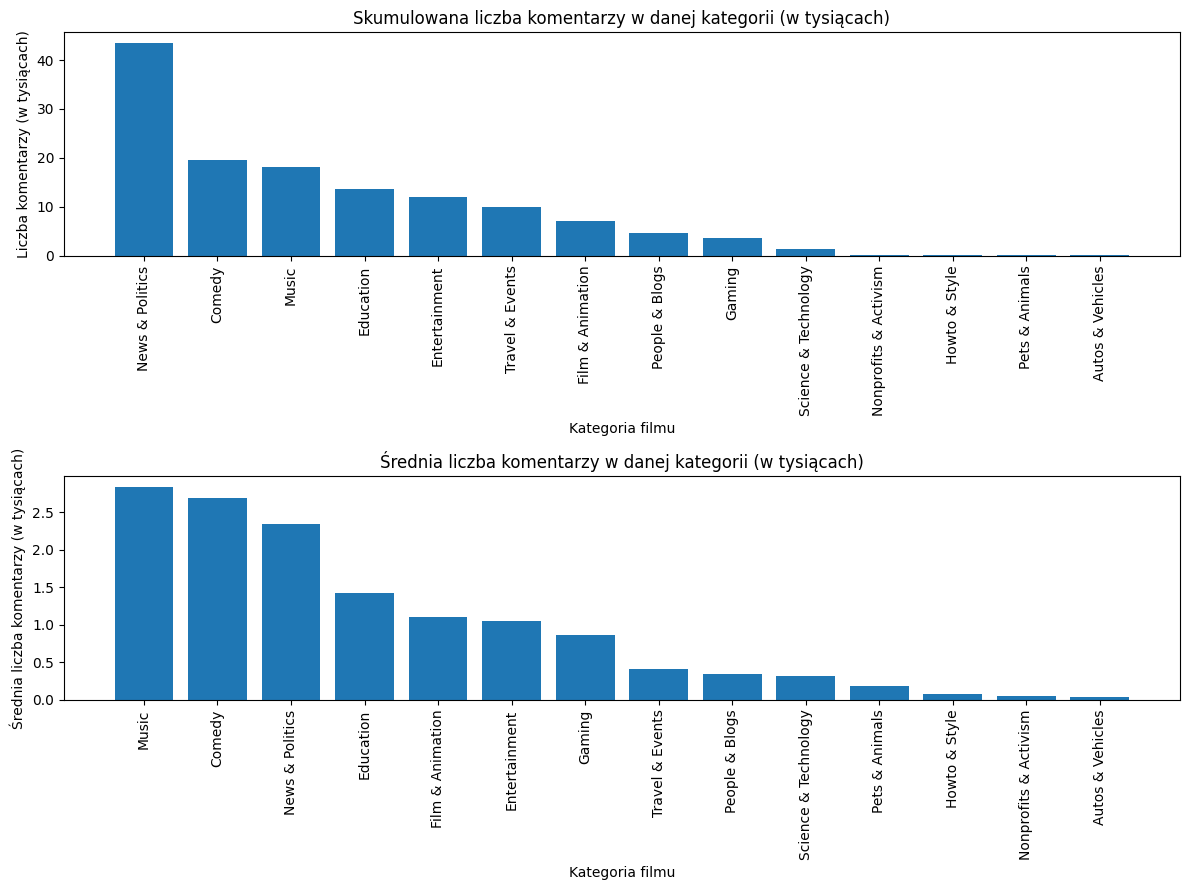

In [80]:
comments_data = data_cat.sort_values(by = "Liczba komentarzy", ascending= False)
comments_data["Liczba komentarzy w tysiącach"] = comments_data["Liczba komentarzy"]/1000

comments_data_mean = comments_data.groupby("Kategorie filmu")["Liczba komentarzy"].mean().reset_index().sort_values(by ="Liczba komentarzy", ascending=False)
comments_data_mean = comments_data_mean.rename(columns={"Liczba komentarzy": "Średnia komentarzy"})
comments_data_mean["Średnia komentarzy"] = comments_data_mean["Średnia komentarzy"] / 1000


plt.figure(figsize=(12, 9))

plt.subplot(2,1,1)
plt.bar(comments_data["Kategorie filmu"], comments_data["Liczba komentarzy w tysiącach"])
plt.title('Skumulowana liczba komentarzy w danej kategorii (w tysiącach)')
plt.xlabel('Kategoria filmu')
plt.ylabel('Liczba komentarzy (w tysiącach)')
plt.xticks(rotation=90)

plt.subplot(2,1,2)
plt.bar(comments_data_mean["Kategorie filmu"], comments_data_mean["Średnia komentarzy"])
plt.title('Średnia liczba komentarzy w danej kategorii (w tysiącach)')
plt.xlabel('Kategoria filmu')
plt.ylabel('Średnia liczba komentarzy (w tysiącach)')
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()

Następnie analizie poddano liczbę komentarzy. Największą bezwzględną ilość komentarzy w analizowanych danych zdobyła kategoria wiadomości i polityka (ponad 40 tysięcy), jest to wartość znacznie odstająca od reszty kategorii. Biorąc pod uwagę średnią ilość komentarzy na film w poszczególnych kategoriach możemy wyszczególnić następujące czołowe miejsca w zestawieniu: muzyka, komedia oraz wiadomości i polityka, z wynikami ponad 2 tys.

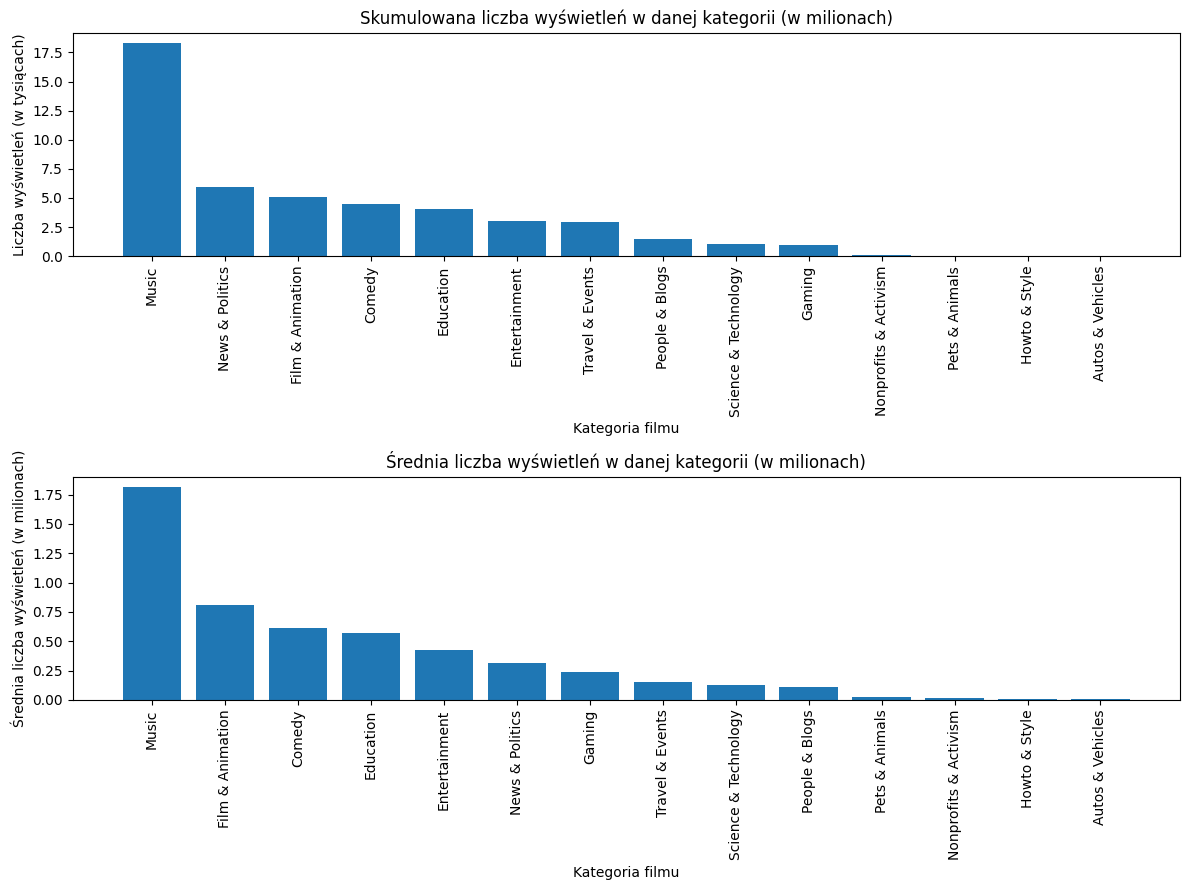

In [81]:
views_data = data_cat.sort_values(by = "Liczba wyświetleń", ascending= False)
views_data["Liczba wyświetleń w milionach"] = views_data["Liczba wyświetleń"]/1000000

views_data_mean = views_data.groupby("Kategorie filmu")["Liczba wyświetleń"].mean().reset_index().sort_values(by ="Liczba wyświetleń", ascending=False)
views_data_mean = views_data_mean.rename(columns={"Liczba wyświetleń": "Średnia wyświetleń"})
views_data_mean["Średnia wyświetleń"] = views_data_mean["Średnia wyświetleń"] / 1000000


plt.figure(figsize=(12, 9))

plt.subplot(2,1,1)
plt.bar(views_data["Kategorie filmu"], views_data["Liczba wyświetleń w milionach"])
plt.title('Skumulowana liczba wyświetleń w danej kategorii (w milionach)')
plt.xlabel('Kategoria filmu')
plt.ylabel('Liczba wyświetleń (w tysiącach)')
plt.xticks(rotation=90)

plt.subplot(2,1,2)
plt.bar(views_data_mean["Kategorie filmu"], views_data_mean["Średnia wyświetleń"])
plt.title('Średnia liczba wyświetleń w danej kategorii (w milionach)')
plt.xlabel('Kategoria filmu')
plt.ylabel('Średnia liczba wyświetleń (w milionach)')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

W ostatnim elemencie analizy popularności poddano liczbę wyświetleń. Na pierwszym wykresie możemy zauważyć, że kategoria muzyki jest zdecydowanie najpopularniejsza pod kątem wyświetleń. Należy jednak zwrócić uwagę, że filmy spod tej kategorii często są wyświetlane więcej razy niż 1, co może mieć znaczny wpływ na wyniki. W skumulowanej liczbie wyświetleń kategoria wiadomości i polityka znajduje się na drugim miejscu osiągając wynik ponad 5 mln komentarzy. Biorąc pod uwagę, że jest to druga najczęściej występująca kategoria osiąga dosyć niski wynik, zajmując VI miejsce w rankingu średniej ilości komentarzy. Podobnie w przypadku najczęściej występującej kategorii tj. podróże i wydarzenia, w rankingu średniej ilości wyświetleń na film plasuje się ona na zaledwie VIII miejscu.

Podsumowując, najpopularniejszą kategorią (wzbudzającą najwięcej aktywności) jest muzyka. Należy jednak zwrócić uwagę na stosunek ilości polubień a komentarzy w przypadku kategorii wiadomości i polityka, która jest drugą najczęściej występującą kategorią. Pomimo zdecydowanie mniejszej ilości średniej wyświetleń w stosunku do czołowych kategorii w tym rankingu, zdobywa niską ilość polubień, natomiast wysoką ilość komentarzy. Może to być oznaczać, że ta kategoria wzbudza najwięcej emocji oraz dyskusji. 

### **Zalezności**

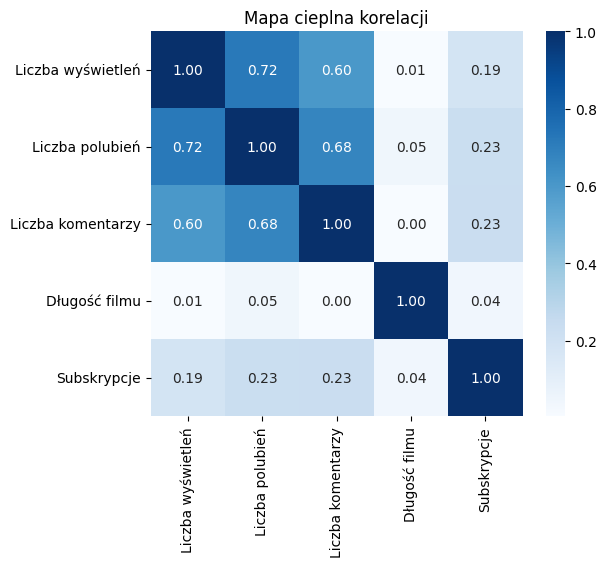

In [82]:
plt.figure(figsize=(6, 5))
corr = data_cat.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot = True,  cmap='Blues', fmt=".2f")
plt.title("Mapa cieplna korelacji")
plt.show()

Obserwuje się silną dodatnią korelacje między liczbą wyświetleń a liczbą polubień oraz liczbą komentarzy. Wskazuje to na tendencję do generowania większej liczby interakcji wśród widzów dla popularnych filmów. Pozostałe cechy są słabo skorelowane ale dodatnio (co oznacza że wzrost jednej cechy może mieć wpływ na wzrost drugiej cechy) bądź nieskorelowane ze sobą. Długość filmu wydaje się nie mieć wpływu na te wskaźniki, natomiast subskrypcje kanału, który udostępnił film mają niewielki wpływ na liczbę wyświetleń, polubień czy komentarzy. 

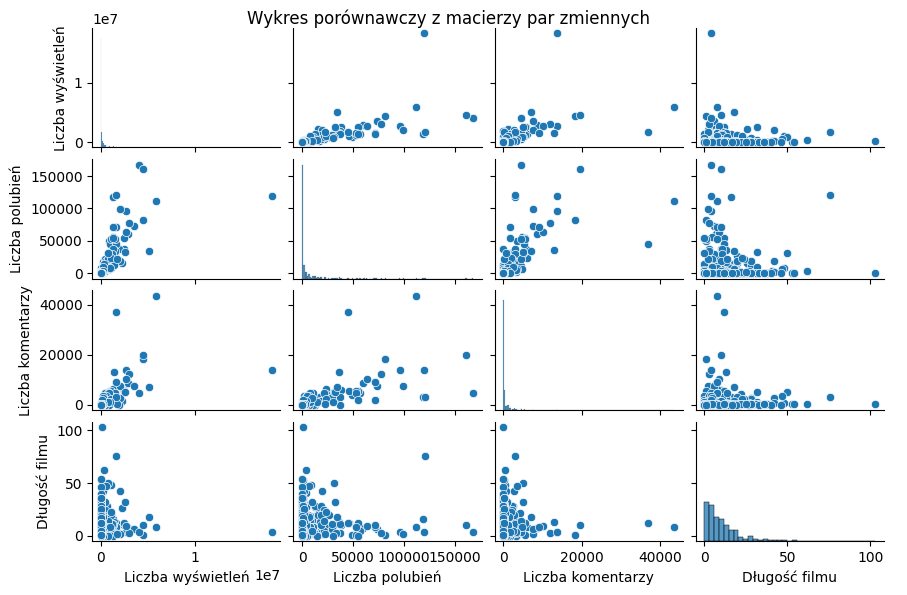

In [83]:
plot = sns.pairplot(data=data_cat, vars =['Liczba wyświetleń', 'Liczba polubień', 'Liczba komentarzy', 'Długość filmu'], kind="scatter", height=1.5, aspect=1.5)
plot.add_legend()
plot.fig.suptitle("Wykres porównawczy z macierzy par zmiennych")
plt.subplots_adjust(top=0.95)
plt.show()

Wykres nie wykazuje obszarów potencjalnych do pogrupowania, nie zauważono żadnych skupień.

### **Długość filmów**

Długość filmów ma zanczenie w wyborze danych do analizy transkrypcji

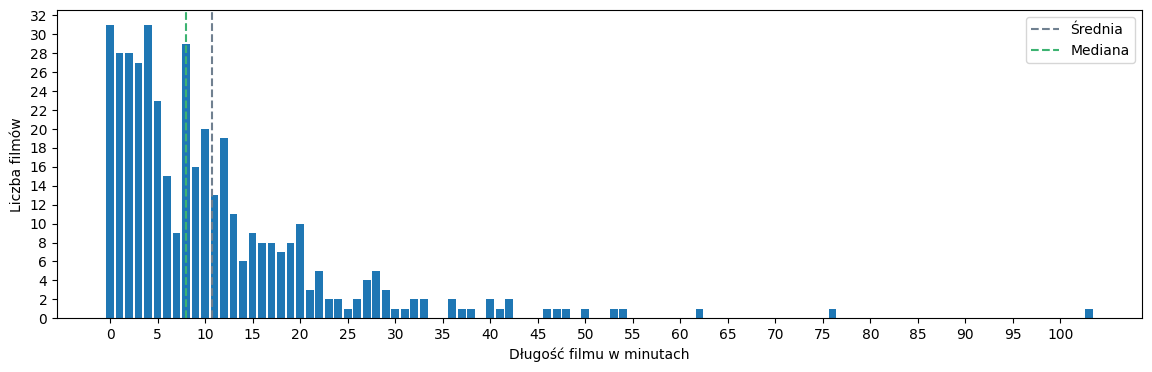

In [84]:
length = data.groupby("Długość filmu")["Tytuł"].count().reset_index()
length = length.rename(columns = {"Tytuł" : "Liczba filmów"})

plt.figure(figsize=(14,4))
#data["Długość filmu"].value_counts().sort_index().plot(kind = "bar")
plt.bar(length["Długość filmu"], length["Liczba filmów"])
#plt.title("Liczba filmów o danej długości")
plt.xlabel("Długość filmu w minutach")
plt.ylabel("Liczba filmów")
plt.yticks(np.arange(0, max(length["Liczba filmów"]) + 2, 2))
plt.xticks(np.arange(0, max(length["Długość filmu"]) + 2, 5))
#plt.grid(alpha =0.3)

mean_line = np.mean(data["Długość filmu"])
median_line = np.median(data["Długość filmu"])
plt.axvline(x=mean_line, color='slategray', linestyle='--', label='Średnia')
plt.axvline(x=median_line, color='mediumseagreen', linestyle='--', label='Mediana')
plt.legend()


Kolejny wykres przedstawia liczbę filmów o danej długości w minutach (długości filmów zostały zaokrąglone do zera miejsc po przecinku). Ponadto zostały nałożone statystyki: średnia i mediana. Obserwuje się najwięcej filmów trwających od 0 do 5 minut. Ogólnie rzecz biorąc liczba filmów maleje wraz ze wzrostem czasu trwania. Mniej więcej od długości na poziomie 40 minut obserwuje się pojedyncze filmy. Najdłuższy film w bazie ma ponad 100 minut. Średnia długości czasu trwania filmu na YouTube w bazie wynosi 8 minut, natomiast mediana 11 minut.

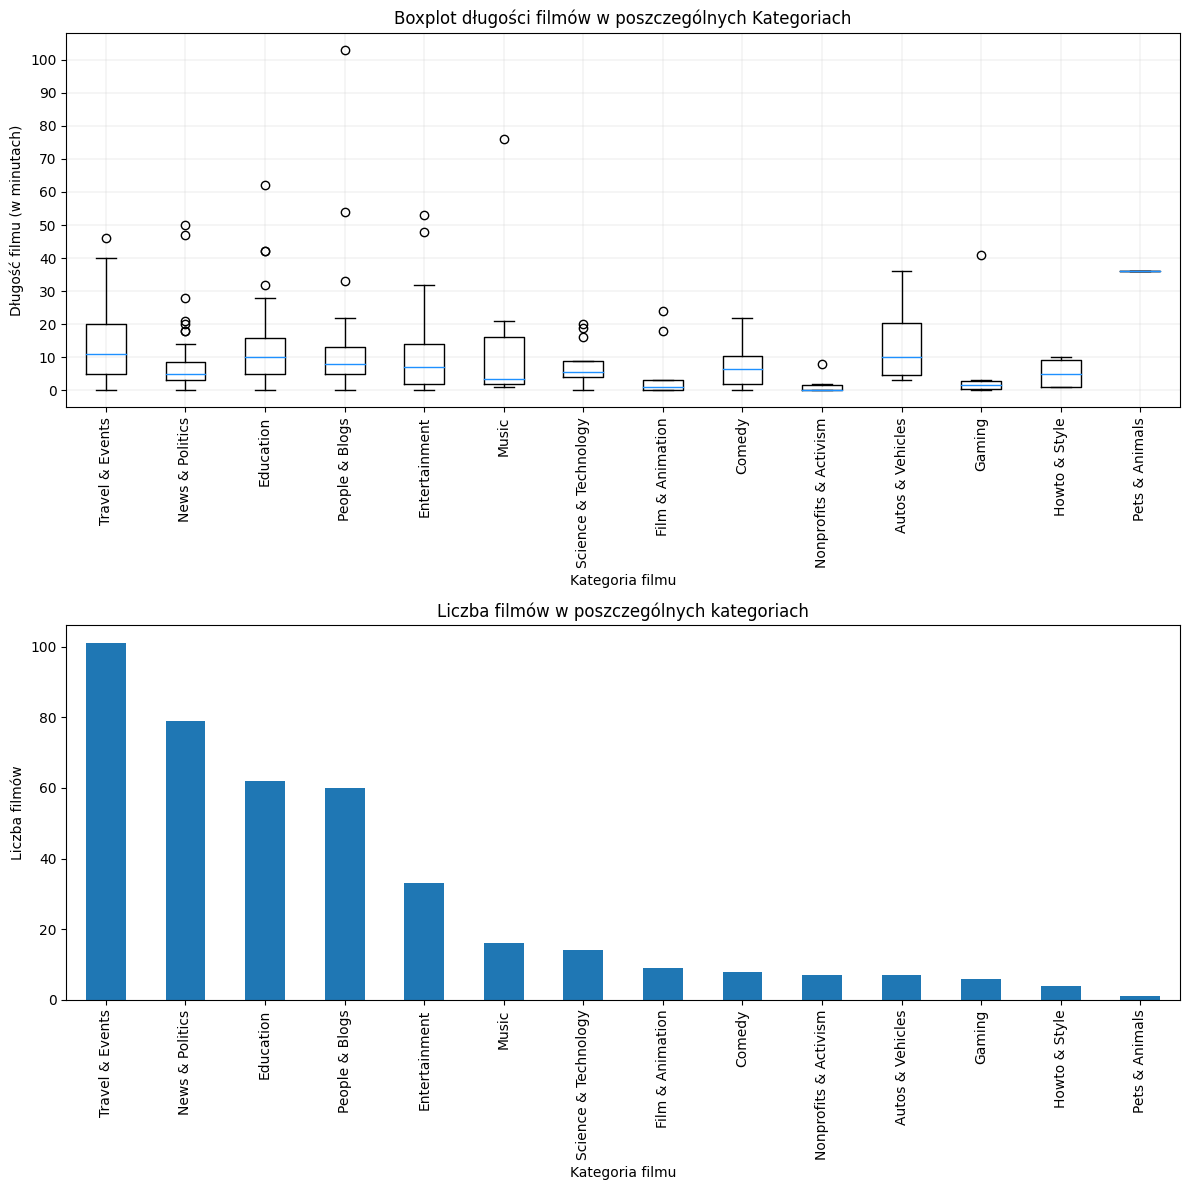

In [85]:
sorted_categories = data_cat["Kategorie filmu"].value_counts().index


plt.figure(figsize=(12,12))

plt.subplot(2, 1, 1)
plt.boxplot([data_cat[data_cat["Kategorie filmu"] == category]["Długość filmu"] for category in sorted_categories], labels=sorted_categories, medianprops=dict(color='dodgerblue'))
plt.title('Boxplot długości filmów w poszczególnych Kategoriach')
plt.xlabel('Kategoria filmu')
plt.ylabel('Długość filmu (w minutach)')
plt.xticks(rotation = 90)
plt.yticks(range(0, int(max(data_cat["Długość filmu"])) + 1, 10))  # Set y-axis ticks every 5 units
plt.grid(color='lightgray', linewidth=0.3)

plt.subplot(2, 1, 2) #ten wykres na przypomnienie i ulatweinei interpreatcji
data_cat["Kategorie filmu"].value_counts().plot(kind = "bar")
plt.title('Liczba filmów w poszczególnych kategoriach')
plt.xlabel('Kategoria filmu')
plt.ylabel('Liczba filmów')

plt.xticks(rotation = 90)

plt.tight_layout()
plt.show()

Przyjrzyjmy się boxplotom jeszcze raz, tym razem bez outliersów aby mediany były bardziej widoczne. Outliersy byłyby problemem w przypadku za krótkich filmów, za długie nie stanowią problemu

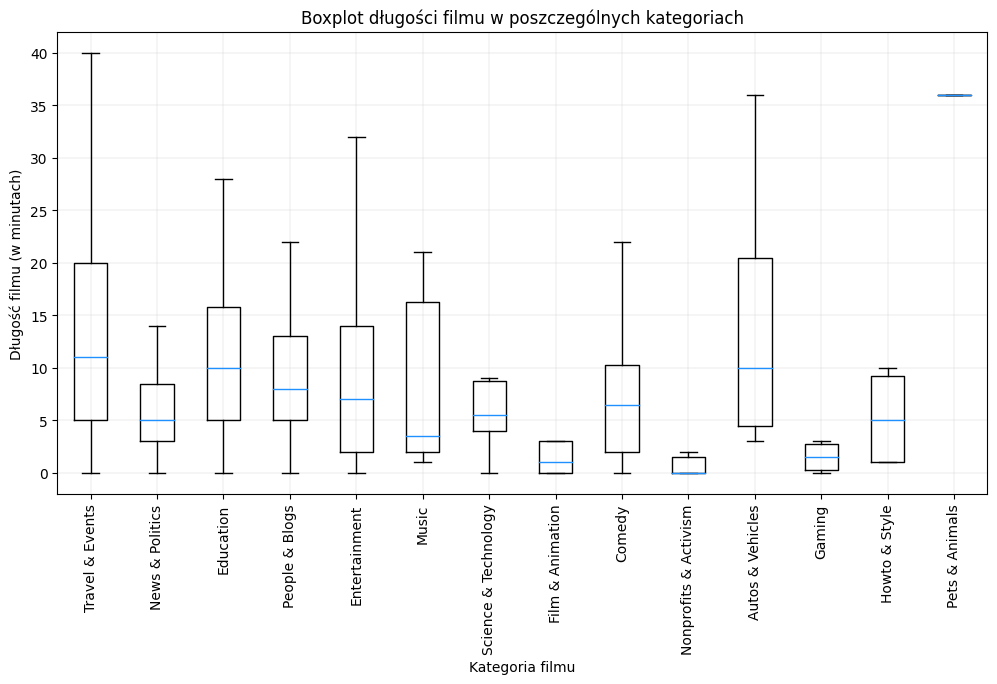

In [86]:
plt.figure(figsize=(12,6))
plt.boxplot([data_cat[data_cat["Kategorie filmu"] == category]["Długość filmu"] for category in sorted_categories], labels=sorted_categories, showfliers=False, medianprops=dict(color='dodgerblue'))
plt.title('Boxplot długości filmu w poszczególnych kategoriach')
plt.xlabel('Kategoria filmu')
plt.ylabel('Długość filmu (w minutach)')
plt.xticks(rotation = 90)
plt.grid(color='lightgray', linewidth=0.3)
plt.show()

In [87]:
data_cut3 = data.copy()
data_cut3 = data_cat[data_cat["Długość filmu"] >= 3]
data_cut4 = data.copy()
data_cut4 = data_cat[data_cat["Długość filmu"] >= 4]
print("Liczba filmów w bazie: ",len(data))
print("Liczba filmów trwających równo bądź dłuzej niz 3 minut: ", len(data_cut3))
print("Liczba filmów trwających równo bądź dłuzej niz 4 minut: ", len(data_cut4))

Liczba filmów w bazie:  407
Liczba filmów trwających równo bądź dłuzej niz 3 minut:  320
Liczba filmów trwających równo bądź dłuzej niz 4 minut:  293


Przyjrzyjmy się teraz nowym zbiorm 

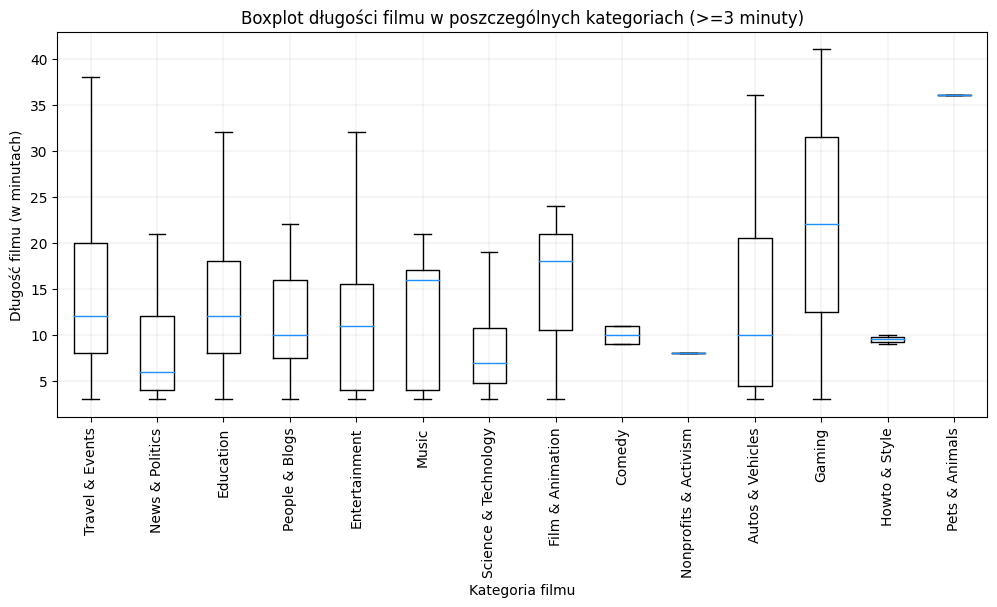

In [88]:
plt.figure(figsize=(12,5))
plt.boxplot([data_cut3[data_cut3["Kategorie filmu"] == category]["Długość filmu"] for category in sorted_categories], labels=sorted_categories, showfliers=False, medianprops=dict(color='dodgerblue'))
plt.title('Boxplot długości filmu w poszczególnych kategoriach (>=3 minuty)')
plt.xlabel('Kategoria filmu')
plt.ylabel('Długość filmu (w minutach)')
plt.xticks(rotation = 90)
plt.grid(color='lightgray', linewidth=0.3)
plt.show()

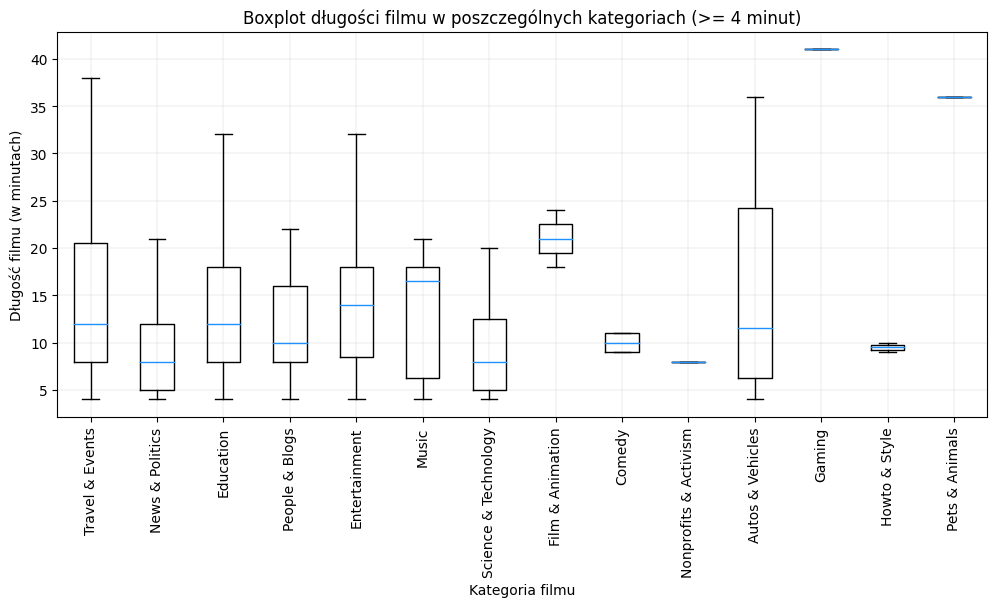

In [89]:
plt.figure(figsize=(12,5))
plt.boxplot([data_cut4[data_cut4["Kategorie filmu"] == category]["Długość filmu"] for category in sorted_categories], labels=sorted_categories, showfliers=False, medianprops=dict(color='dodgerblue'))
plt.title('Boxplot długości filmu w poszczególnych kategoriach (>= 4 minut)')
plt.xlabel('Kategoria filmu')
plt.ylabel('Długość filmu (w minutach)')
plt.xticks(rotation = 90)
plt.grid(color='lightgray', linewidth=0.3)
plt.show()

Poniewaz klasteryzacja bedzie przeprowadzona na transkrypcjach, przed podjęciem decyzji o tym jakie filmy zostawić przyjrzyjmy się jeszcze blizej tej kolumnie (sekcja "przygotowanie transkrypcji (czyszczenie))

<hr>

# Przygotowanie transkrypcji (czyszczenie)

In [90]:
transcripts_cleaned = data["Transkrypcja"]
transcripts_cleaned

0      Good morning Before granting you entry to Pola...
1      this video is sponsored by hubsports this is P...
2      After the devastation it suffered in World\nWa...
3      Poland is becoming an intimidating military\nf...
4      This number, 226, is the percentage increase\n...
                             ...                        
494    Hello friends! This video will be about\ncross...
495    winter in zakopane, poland december 2022, chri...
496    hello and welcome back to borders today we're ...
497    countries as superheroes part two AI generated...
499    Global Management Challenge is the world's lar...
Name: Transkrypcja, Length: 407, dtype: object

#### małe znaki i interpunkcja i znaki inne niz teskt

In [91]:
transcripts_cleaned = transcripts_cleaned.apply(lambda x: ''.join(' ' if char == '\n' else char.lower() for char in x))

transcripts_cleaned = transcripts_cleaned.apply(lambda x: ''.join(char.lower() for char in x if char not in string.punctuation))

transcripts_cleaned

0      good morning before granting you entry to pola...
1      this video is sponsored by hubsports this is p...
2      after the devastation it suffered in world war...
3      poland is becoming an intimidating military fo...
4      this number 226 is the percentage increase in ...
                             ...                        
494    hello friends this video will be about crossin...
495    winter in zakopane poland december 2022 christ...
496    hello and welcome back to borders today were h...
497    countries as superheroes part two ai generated...
499    global management challenge is the worlds larg...
Name: Transkrypcja, Length: 407, dtype: object

#### Lemmatyzacja

In [92]:
nlp = spacy.load('en_core_web_sm')

transcripts_cleaned = transcripts_cleaned.apply(lambda x: ' '.join(word.lemma_ for word in nlp(x)))
transcripts_cleaned
#2 minuty 40 sek

0      good morning before grant you entry to poland ...
1      this video be sponsor by hubsport this be pola...
2      after the devastation it suffer in world war i...
3      poland be become an intimidate military force ...
4      this number 226 be the percentage increase in ...
                             ...                        
494    hello friend this video will be about cross th...
495    winter in zakopane poland december 2022 christ...
496    hello and welcome back to border today be head...
497    country as superhero part two ai generate illu...
499    global management challenge be the world large...
Name: Transkrypcja, Length: 407, dtype: object

#### stopwords

In [93]:
stop_words = set(stopwords.words('english'))
custom_stop_words = set(['poland', 'polish', 'yeah', 'oh', 'what', 'whats', 'uh', 'morning', 'I', "'", 'hi', "th", 'aghaha', 'ah', 'ahaha', 'ahahaha', 'hah', 'haha', 'hahaha', 'yah', 'waah', 'ahuh', "до", "перемоги", "поляна", "царская", "úa", "aa", "aaa", "’," "aani", "aaron", "s"])
stop_words.update(custom_stop_words)

transcripts_cleaned = transcripts_cleaned.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
transcripts_cleaned

0      good grant entry must first answer simple ques...
1      video sponsor hubsport country home 38 million...
2      devastation suffer world war ii struggle natio...
3      become intimidate military force europe ’s mak...
4      number 226 percentage increase size economy gd...
                             ...                        
494    hello friend video cross border terespol brest...
495     winter zakopane december 2022 christmas zakopane
496    hello welcome back border today head east musi...
497    country superhero part two ai generate illustr...
499    global management challenge world large strate...
Name: Transkrypcja, Length: 407, dtype: object

#### liczby i liczby sklejone z tekstem

In [94]:
#transcripts_cleaned = transcripts_cleaned.apply(lambda x: re.sub(r'\b\d+\w+\b|\d+', '', x)) #\d+ minimum jedna cyfra, \w+ a potem minimum jedna litera | lub \d+ minimum jedna cyfra

transcripts_cleaned = transcripts_cleaned.apply(lambda x: re.sub(r'\d+', '', x))
transcripts_cleaned = transcripts_cleaned.apply(lambda x: re.sub(r'\d+\w+', '', x))

transcripts_cleaned

0      good grant entry must first answer simple ques...
1      video sponsor hubsport country home  million p...
2      devastation suffer world war ii struggle natio...
3      become intimidate military force europe ’s mak...
4      number  percentage increase size economy gdp p...
                             ...                        
494    hello friend video cross border terespol brest...
495         winter zakopane december  christmas zakopane
496    hello welcome back border today head east musi...
497    country superhero part two ai generate illustr...
499    global management challenge world large strate...
Name: Transkrypcja, Length: 407, dtype: object

### zamiana podobnych słów (lub słów z błędami) na jedno

In [95]:
transcripts_cleaned = transcripts_cleaned.str.replace(r'\beuropean\b|\beu\b', 'europe', case=False)
transcripts_cleaned = transcripts_cleaned.str.replace(r'\bworld war II\b', 'wwii', case=False)
transcripts_cleaned = transcripts_cleaned.str.replace(r'\bżapka\b', 'żabka', case=False)
transcripts_cleaned = transcripts_cleaned.str.replace(r'\babbot\b', 'abbott', case=False)
transcripts_cleaned = transcripts_cleaned.str.replace(r'\bukrainian\b', 'ukraine', case=False)

#### zapisanie oczyszczonych transkrypcji do bazy

In [96]:
data['Transkrypcja oczyszczona'] = transcripts_cleaned
data_cat['Transkrypcja oczyszczona'] = transcripts_cleaned #dodaje do drugiej wersji zbioru - z nawami kategroii
data


,Tytuł,Data publikacji,Liczba wyświetleń,Liczba polubień,Liczba komentarzy,Tagi filmu,Kategorie filmu,Channel_id,Długość filmu,Rodzaj filmu,video_id,Nazwa kanalu,Kraj kanału,Subskrypcje,Transkrypcja,Transkrypcja oczyszczona
0,Getting Past Polish Immigration,2023-11-09T08:00:31Z,299271,18467,1173,"['Foil Arms and Hog', 'sketch comedy', 'comedy...",23,UCzb-6smlTg5UPirLdsdQ_cQ,2,hd,flwcUmS_8Ws,Foil Arms and Hog,IE,923000,Good morning Before granting you entry to Pola...,good grant entry must first answer simple ques...
1,Could Poland Become The Next Germany? | Econom...,2023-10-08T15:05:13Z,461061,12698,1939,"['economics', 'economics explained', 'economy ...",27,UCZ4AMrDcNrfy3X6nsU8-rPg,19,hd,p9Tnjr3Lluk,Economics Explained,US,2390000,this video is sponsored by hubsports this is P...,video sponsor hubsport country home million p...
2,How Poland is Becoming Europe's Next Military ...,2023-09-10T19:15:01Z,477721,13108,1924,[],27,UCfdNM3NAhaBOXCafH7krzrA,27,hd,pEeAAyIFf8Y,The Infographics Show,US,13600000,After the devastation it suffered in World\nWa...,devastation suffer world war ii struggle natio...
3,Could the Russian Military Conquer Poland on I...,2023-10-31T22:00:11Z,357857,4706,1368,"['us', 'military', 'us military', 'us navy', '...",28,UCKfak8fBm_Lhy4eX9UKxEpA,19,hd,H-KH0vls1zU,The Military Show,US,664000,Poland is becoming an intimidating military\nf...,become intimidate military force europe ’s mak...
4,Poland's Path to Becoming the Next Advanced Ec...,2023-10-20T11:52:27Z,189518,3857,1118,"['economy of poland', 'poland economics explai...",27,UCyHJ94JzwY92NsBVzJ2aE3Q,12,hd,gzbtAJ7x_mg,Econ,IN,91600,"This number, 226, is the percentage increase\n...",number percentage increase size economy gdp p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,Crossing Poland - Belarus border on a train. B...,2019-07-02T10:25:07Z,14888,162,42,"['border cross', 'belarus', 'brest', 'train', ...",19,UCFupYo1rCjNfuzZK_SfUkFw,5,hd,Z8vzk-4cTEQ,Nomadic Dmitry,US,6800,Hello friends! This video will be about\ncross...,hello friend video cross border terespol brest...
495,"""SEA EYE"" ZAKOPANE POLAND DECEMBER 2022 ❄ AMAZ...",2022-12-21T11:50:22Z,247,10,3,"['SEA EYE', 'ZAKOPANE', 'ZAKOPANE POLAND', 'ZA...",19,UCfU2X_rOIXA-t0A8KgwmHOQ,0,hd,PS-EZLpH6uI,4K Relaxing City Walks,GB,1770,"winter in zakopane, poland december 2022, chri...",winter zakopane december christmas zakopane
496,Poland explained in 60 seconds!🇵🇱 #geography #...,2022-03-03T23:54:50Z,12770,496,23,[],27,UCcC5AasdcqtvR2aNCBKUQsA,1,hd,5JFYZvpz1AE,Rounded Kids,GB,1010,hello and welcome back to borders today we're ...,hello welcome back border today head east musi...
497,Countries as Super Heroes!🦸🦹PART 2! AI FUN #ai...,2023-01-16T22:45:00Z,1694,55,3,"['ai', 'funfacts', 'usa', 'poland', 'brazil', ...",28,UCCcycw_uukrBthI89-pyA9Q,0,hd,HPOF0uCwLwU,THE CURIOSITY CORNER,US,589,countries as superheroes part two AI generated...,country superhero part two ai generate illustr...


## Orientacyjna chmura słów

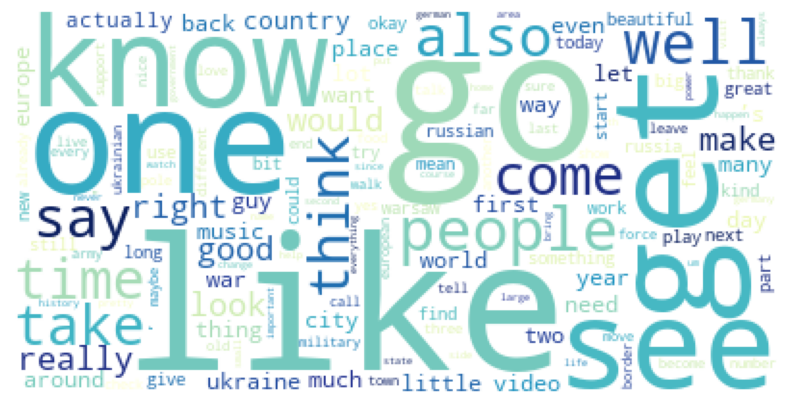

In [97]:
text = ' '.join(transcripts_cleaned)
tags = text.split()

tag_counts = Counter(tags)
wordcloud = WordCloud(background_color= 'white', colormap='YlGnBu').generate_from_frequencies(tag_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [98]:
tag_counts.most_common(10)

[('like', 3361),
 ('go', 3296),
 ('one', 2075),
 ('get', 2027),
 ('know', 1809),
 ('see', 1727),
 ('people', 1524),
 ('well', 1442),
 ('also', 1309),
 ('time', 1254)]

In [99]:
tag_counts['warsaw']

585

## Ostateczne przygotowanie do grupowania

Sprawdźmy teraz średnią liczbę słów (nadających się do analizy tj z oczyszczonyego tekstu) w filmie w zaleznosci od dlugosci filmu 

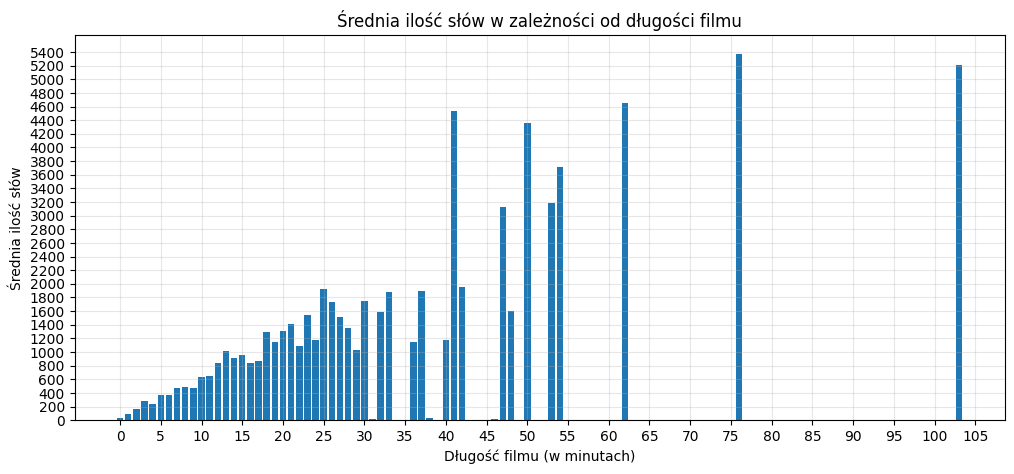

In [100]:
data["Liczba słów (po oczyszczeniu)"] = data["Transkrypcja oczyszczona"].apply(lambda x: len(x.split()))
data_cat["Liczba słów (po oczyszczeniu)"] = data_cat["Transkrypcja oczyszczona"].apply(lambda x: len(x.split())) # na wszelki wypadek zapisuje rowniez kolumne wynikowa do zbioru z nazwami kategorii


average_words = data.groupby("Długość filmu")["Liczba słów (po oczyszczeniu)"].mean().reset_index()

plt.figure(figsize=(12,5))
plt.bar(average_words["Długość filmu"], average_words["Liczba słów (po oczyszczeniu)"])
plt.title('Średnia ilość słów w zależności od długości filmu')
plt.xlabel('Długość filmu (w minutach)')
plt.ylabel('Średnia ilość słów')
plt.yticks(np.arange(0, max(average_words["Liczba słów (po oczyszczeniu)"]) + 100, 200))
plt.xticks(np.arange(0, max(average_words["Długość filmu"]) + 5, 5))
plt.grid(alpha = 0.3)
plt.show()

Przyjrzyjmy się jeszcze blizej nizszym wartościom

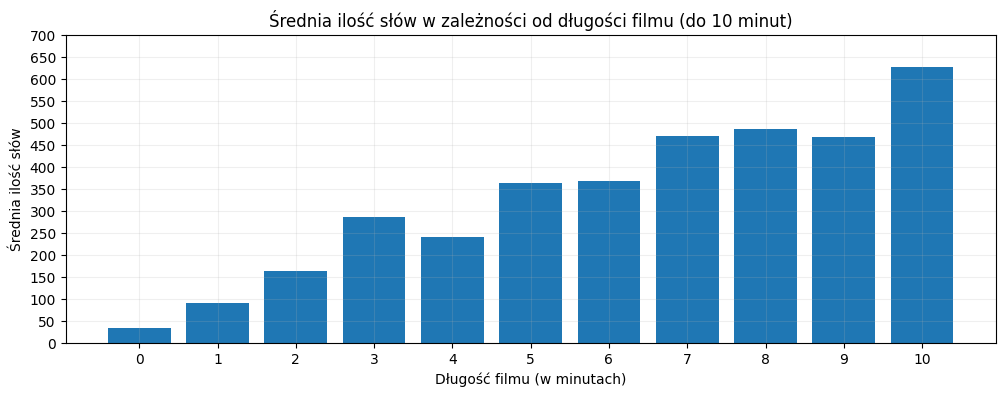

In [101]:

average_words = average_words.head(11)

plt.figure(figsize=(12,4))
plt.bar(average_words["Długość filmu"], average_words["Liczba słów (po oczyszczeniu)"])
plt.title('Średnia ilość słów w zależności od długości filmu (do 10 minut)')
plt.xlabel('Długość filmu (w minutach)')
plt.ylabel('Średnia ilość słów')
plt.yticks(np.arange(0, max(average_words["Liczba słów (po oczyszczeniu)"]) + 100, 50))
plt.xticks(np.arange(0, max(average_words["Długość filmu"]) + 1, 1))
plt.grid(alpha = 0.2)
plt.show()

In [102]:
print("Najmniej słów w filmach:", min(data["Liczba słów (po oczyszczeniu)"]))
print("Najwięcej słów w filmach:", max(data["Liczba słów (po oczyszczeniu)"]) - min(data["Liczba słów (po oczyszczeniu)"]))
print("Róznica:", max(data["Liczba słów (po oczyszczeniu)"]))
print("Mediana słów w filmach:",(data["Liczba słów (po oczyszczeniu)"].median()))

Najmniej słów w filmach: 1
Najwięcej słów w filmach: 5376
Róznica: 5377
Mediana słów w filmach: 443.0


Do analizy zostaną wzięte pod uwagę filmy o liczbie słów większej niz 30. Pozostałe róznice w liczbie słów nie stanowią problemu w przyapdku uzycia macierzy TF-IDF 

In [103]:
data_cat[data_cat["Liczba słów (po oczyszczeniu)"] < 30]

,Tytuł,Data publikacji,Liczba wyświetleń,Liczba polubień,Liczba komentarzy,Tagi filmu,Kategorie filmu,Channel_id,Długość filmu,Rodzaj filmu,video_id,Nazwa kanalu,Kraj kanału,Subskrypcje,Transkrypcja,Transkrypcja oczyszczona,Liczba słów (po oczyszczeniu)
35,Warsaw By Night - Warszawa nocą z drona | Pola...,2020-12-13 18:21:22+00:00,630266,11585,1930,"['warsaw by night', 'poland on air', 'warsaw',...",Travel & Events,UCeHvFc-vcuWf69VXizY2Cvg,4,hd,veayhCb_W8M,POLAND ON AIR,PL,23500,Enjoy Warsaw from above in our photobook\nWARS...,enjoy warsaw photobook warsaw air available ww...,10
65,Lil Yachty - Poland (Lyrics),2022-10-16 14:51:14+00:00,52165,742,80,[],Music,UCRj_YzvblVTAbL6SJxuoWAg,1,hd,OmG2S17Td3o,Rap Paradise,US,752000,filthy [Music] to Poland [Music] [Music] hope ...,filthy music music music hope love baby music ...,11
136,Poland Trailer - Family Travel Season 7,2022-01-03 18:43:37+00:00,653,10,0,"['travel', 'family travel', 'poland', 'krakow'...",Travel & Events,UC8mYMwoT_qNfxKAc7wXtR0Q,2,hd,iUv-X301peo,Family Travel,US,4820,"Hi I'm Colleen Kelly, and this is \n""Family Tr...",colleen kelly family travel welcome wieliczka ...,22
152,"Russian missiles hit Poland, killing 2, as Ukr...",2022-11-15 19:07:54+00:00,326525,1967,3258,"['news', 'russia poland', 'poland missiles', '...",News & Politics,UC_vFLohxs5PkAxlk7Y6jEtw,0,hd,lIXpAipZI_8,ABC 7 Chicago,US,690000,TERRELL: MAJOR RUSSIAN AIR STRIKES ACROSS UKRA...,terrell major russian air strike across ukrain...,24
164,"Kielce, Poland - points of interest and city g...",2018-06-30 15:53:31+00:00,9016,61,6,"['kielce', 'kielce polen', 'kielce flughafen',...",Travel & Events,UCj6nHW9q5mtcYIuBZyK2Ihw,9,hd,9bENijoTA_8,Sehenswürdigkeiten in Europa,DE,2420,Kielce Kielce is the capital of the Świętokrzy...,kielce kielce capital świętokrzyskie province ...,17
203,Countryballs - Poland's not known for mu-,2021-04-10 12:17:00+00:00,1337937,54755,1766,"['poland', 'Polska', 'countryballs', 'USA', 'c...",Film & Animation,UCx22mlTERBqxg30j186hOsA,0,hd,uB_5EruC81o,PolishTortoise,PL,216000,[Music] um hey usa um hey the little european ...,music um hey usa um hey little european countr...,18
221,14 days in Poland l 4K cinematic travel video,2021-10-31 18:14:49+00:00,18299,769,116,"['roadtrip Poland', 'travel video Poland', 'Po...",Travel & Events,UChBqChR3szcZd6KRFx081vg,3,hd,jowU2BeXbno,Šajbi cestuje,Brak danych o kraju,521,Present moment. The only thing you can enjoy \...,present moment thing enjoy waste live live,7
235,Bydgoszcz - walking tour in 4K | Poland,2019-05-22 22:17:46+00:00,11318,141,9,"['bydgoszcz', 'poland', 'walkingtours', 'walki...",Travel & Events,UChTbfkYOzZhuoa6ALdLGHyw,46,hd,MRrbWGfnIkE,Kondel Walking Tours,IT,3780,"Bydgoszcz is a city in northern Poland, on the...",bydgoszcz city northern brda vistula river cit...,15
295,"In Poland we don`t say: ""spoiled"". We say: ""ro...",2023-03-25 12:44:10+00:00,461,17,0,"['miss maja', 'missmaja.pl', 'angielski dla dz...",Education,UCz7xAk9-4nkvBUpjWkUSXPA,0,hd,8EahZ5Y9uxE,Miss Maja,Brak danych o kraju,121,so what do you say in Poland when someone is k...,say someone kind say someone unkind make sense...,16
303,Puck 4K - Poland walking tour,2020-09-18 05:26:20+00:00,11745,127,18,"['Puck', 'Poland', 'BayofPuck', 'GulfofGdansk'...",Travel & Events,UChTbfkYOzZhuoa6ALdLGHyw,31,hd,4lY-EnGrcPQ,Kondel Walking Tours,IT,3780,"Puck is a town in northwestern Poland with 11,...",puck town northwestern inhabitant gdańsk pome...,18


Ciekawe zjawisko, YouTube Api nie radzi sobie z tekstem jezeli jest muzyka?

In [104]:
data_cat.loc[416]["Transkrypcja"]

'You have possibility to avoid work permit If you want to know what I am talking about  watch till the end of the video music ... music ... music ... music ...                                                                                                                                                                                                                                                                                                                                                                                                              '

Pobrałam ten sam film kilka razy, za kazdym razem tak samo. To nie Youtube Api lecz automatyczne generowanie transkrypcji, w filmie równiez nie ma dalszej części 

Tak więc usunięcie filmów zawierających ponizej 30 słów moze odflitorwać takie przypadki

Tworzenie zmiennej do grupowania

In [105]:
dropped_rows = data[data["Liczba słów (po oczyszczeniu)"] < 30].index
dropped_rows

Index([ 35,  65, 136, 152, 164, 203, 221, 235, 295, 303, 306, 307, 316, 322,
       334, 365, 376, 384, 399, 416, 433, 447, 458, 460, 465, 474, 477, 485,
       488, 495, 497],
      dtype='int64')

In [106]:
transcripts_all_clustering = data_cat.copy() #wersja z nazwmai kategorii, poniewaz będą istotne 
transcripts_all_clustering = transcripts_all_clustering.drop(dropped_rows)
print(transcripts_all_clustering.shape)
transcripts_all_clustering.head()

(376, 17)


,Tytuł,Data publikacji,Liczba wyświetleń,Liczba polubień,Liczba komentarzy,Tagi filmu,Kategorie filmu,Channel_id,Długość filmu,Rodzaj filmu,video_id,Nazwa kanalu,Kraj kanału,Subskrypcje,Transkrypcja,Transkrypcja oczyszczona,Liczba słów (po oczyszczeniu)
0,Getting Past Polish Immigration,2023-11-09 08:00:31+00:00,299271,18467,1173,"['Foil Arms and Hog', 'sketch comedy', 'comedy...",Comedy,UCzb-6smlTg5UPirLdsdQ_cQ,2,hd,flwcUmS_8Ws,Foil Arms and Hog,IE,923000,Good morning Before granting you entry to Pola...,good grant entry must first answer simple ques...,141
1,Could Poland Become The Next Germany? | Econom...,2023-10-08 15:05:13+00:00,461061,12698,1939,"['economics', 'economics explained', 'economy ...",Education,UCZ4AMrDcNrfy3X6nsU8-rPg,19,hd,p9Tnjr3Lluk,Economics Explained,US,2390000,this video is sponsored by hubsports this is P...,video sponsor hubsport country home million p...,2005
2,How Poland is Becoming Europe's Next Military ...,2023-09-10 19:15:01+00:00,477721,13108,1924,[],Education,UCfdNM3NAhaBOXCafH7krzrA,27,hd,pEeAAyIFf8Y,The Infographics Show,US,13600000,After the devastation it suffered in World\nWa...,devastation suffer world war ii struggle natio...,2548
3,Could the Russian Military Conquer Poland on I...,2023-10-31 22:00:11+00:00,357857,4706,1368,"['us', 'military', 'us military', 'us navy', '...",Science & Technology,UCKfak8fBm_Lhy4eX9UKxEpA,19,hd,H-KH0vls1zU,The Military Show,US,664000,Poland is becoming an intimidating military\nf...,become intimidate military force europe ’s mak...,1824
4,Poland's Path to Becoming the Next Advanced Ec...,2023-10-20 11:52:27+00:00,189518,3857,1118,"['economy of poland', 'poland economics explai...",Education,UCyHJ94JzwY92NsBVzJ2aE3Q,12,hd,gzbtAJ7x_mg,Econ,IN,91600,"This number, 226, is the percentage increase\n...",number percentage increase size economy gdp p...,1012


In [107]:
transcripts_all_clustering[transcripts_all_clustering["Liczba słów (po oczyszczeniu)"] < 30]

,Tytuł,Data publikacji,Liczba wyświetleń,Liczba polubień,Liczba komentarzy,Tagi filmu,Kategorie filmu,Channel_id,Długość filmu,Rodzaj filmu,video_id,Nazwa kanalu,Kraj kanału,Subskrypcje,Transkrypcja,Transkrypcja oczyszczona,Liczba słów (po oczyszczeniu)


Wiersze usunięte poprawnie

Poniewaz kategorie charakteryzują się duzą dysproporcją, do klasteryzacji wybiorę najpopularniejsze kategorię (70% filmów z ). **ZMIANA**  Zdecydowalam się zostawić wszytskie kategorie, poniewaz zauwazyłam, ze filmy o imigracji do Polski są bardzo róznie okategorzyowane (np w People & Blogs czy Howto &Style są filmy o imigracji)<br>


<hr>

# Grupowanie tematyczne filmów, porównanie wyników

In [108]:
transcripts = transcripts_all_clustering.loc[:, ["Transkrypcja oczyszczona"]].rename(columns={"Transkrypcja oczyszczona": "text"})
transcripts

,text
0,good grant entry must first answer simple ques...
1,video sponsor hubsport country home million p...
2,devastation suffer world war ii struggle natio...
3,become intimidate military force europe ’s mak...
4,number percentage increase size economy gdp p...
...,...
492,hey travel buddy kat cezary one kiwicom world ...
493,go bad vlog life know love bread thing thing c...
494,hello friend video cross border terespol brest...
496,hello welcome back border today head east musi...


#### Przetworzenie tekstu na wektory tf-idf

In [109]:
vectorizer = TfidfVectorizer() #197 termów mniej gdy dodam ponownie stop words (stop_words('english'))
tfidf = vectorizer.fit_transform(transcripts["text"])
tfidf

<376x17147 sparse matrix of type '<class 'numpy.float64'>'
	with 119623 stored elements in Compressed Sparse Row format>

Sprawdźmy czy wynik jest prawdopobny:

In [110]:
text_original = ' '.join(transcripts_all_clustering["Transkrypcja oczyszczona"])
terms_original = text_original.split()
print("Wymiary macierzy tdifd: ", tfidf.shape[1]," x ", tfidf.shape[0])
print("Liczba unikalnych tagów na podstawie kolumny 'Transkrypcja oczyszczona: ",len(set(terms_original)))
print("Liczba filmów (wierszy): ", len(transcripts))
print("Róznica w kolumnach (termach): ", tfidf.shape[1]-len(set(terms_original)))

Wymiary macierzy tdifd:  17147  x  376
Liczba unikalnych tagów na podstawie kolumny 'Transkrypcja oczyszczona:  17205
Liczba filmów (wierszy):  376
Róznica w kolumnach (termach):  -58


macierz tfidf wydaje sie byc zbudowana poprawnie

In [111]:
matrix = tfidf.toarray()
matrix = pd.DataFrame(matrix)
feauter_names = vectorizer.get_feature_names_out()
matrix.columns = feauter_names
matrix

,aani,abalone,abandon,abandoned,abbas,abbot,abbott,abbreviation,abby,abc,...,świętokrzyskie,šiauliai,żabka,żaneta,żapka,żeligowski,żółkiewski,аnd,водка,еven
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.011574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.08381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
373,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
sparsity = 1.0 - tfidf.nnz / (tfidf.shape[0] * tfidf.shape[1])
print("Rzadkość macierzy: ", round(sparsity,2))

Rzadkość macierzy:  0.98


97% elementów w macierzy TF-IDF są równe zeru

In [113]:
print("Najbardziej znaczące słowa: ")
matrix.mean().sort_values(ascending=False)[:20]


Najbardziej znaczące słowa: 


like       0.062365
go         0.061097
get        0.039934
one        0.038070
know       0.036764
see        0.035244
people     0.034134
music      0.033543
ukraine    0.029771
say        0.028467
well       0.028364
country    0.027987
think      0.027981
really     0.027283
city       0.026361
come       0.025914
also       0.025840
time       0.025392
look       0.025195
right      0.024612
dtype: float64

In [114]:
print("Najmniej znaczące słowa: ")
matrix.mean().sort_values()[:25]

Najmniej znaczące słowa: 


fave               0.000009
aficionado         0.000009
brooks             0.000009
rtm                0.000009
urzaya             0.000009
sidestep           0.000009
valerie            0.000009
ftx                0.000009
temo               0.000009
pragmatic          0.000009
grandmaster        0.000009
fittingly          0.000009
afterward          0.000009
ac                 0.000009
teemo              0.000009
retrospect         0.000009
timofev            0.000009
speedch            0.000009
blackwell          0.000009
catalan            0.000009
multifunctional    0.000009
granola            0.000009
gamut              0.000009
fianchettoe        0.000009
sabrina            0.000009
dtype: float64

## Redukcja wymiarów

Osypisko

#### PCA

In [115]:
pca = PCA(n_components=3, random_state=0)
matrix_pca = pca.fit_transform(matrix)
variance_pca = pca.explained_variance_ratio_

print(f"Pierwsza składowa (PCA1) wyjaśnia {variance_pca[0]:.2f}% wariancji")
print(f"Druga składowa (PCA2) wyjaśnia {variance_pca[1]:.2f}% wariancji")
print(f"Trzecia składowa (PCA3) wyjaśnia {variance_pca[2]:.2f}% wariancji")


Pierwsza składowa (PCA1) wyjaśnia 0.03% wariancji
Druga składowa (PCA2) wyjaśnia 0.02% wariancji
Trzecia składowa (PCA3) wyjaśnia 0.01% wariancji


Sprawdzmy ile n_clusters nalezy dobrac e celu otrzymania lepszych wyników:

In [116]:
variance_90 = PCA(n_components=0.90)
variance_90.fit_transform(matrix)
components_90 = variance_90.n_components_

print(f"Do wyjaśneinia 90% wariancji trzeba {components_90} składowych głównych")

Do wyjaśneinia 90% wariancji trzeba 290 składowych głównych


In [117]:
variance_70 = PCA(n_components=0.70)
variance_70.fit_transform(matrix)
variance_70 = variance_70.n_components_

print(f"Do wyjaśneinia 70% wariancji trzeba {variance_70} składowych głównych")

Do wyjaśneinia 70% wariancji trzeba 184 składowych głównych


Zostajemy przy 3, w celu przyszłych wizualizacji

In [ ]:
fig = px.scatter_3d(x=matrix_pca[:, 0], y=matrix_pca[:, 1], z=matrix_pca[:, 2],
                    size_max=30, opacity=0.7,
                    labels = {"x" :"PCA1", "y": "PCA2", "z" : "PCA3"})

fig.update_layout(title ="PCA", title_x =0.5, title_y=0.9, width=800, height=800)

fig.show()

### Truncated SVD

In [ ]:
svd = TruncatedSVD(n_components=3, random_state=0)
matrix_svd = svd.fit_transform(matrix)
variance_svd = svd.explained_variance_ratio_

print(f"\nPierwsza składowa (SVD1) wyjaśnia {variance_svd[0]:.2f}% wariancji")
print(f"Druga składowa (SVD2) wyjaśnia {variance_svd[1]:.2f}% wariancji")
print(f"Trzecia składowa (SVD3) wyjaśnia {variance_svd[2]:.2f}% wariancji")



Pierwsza składowa (SVD1) wyjaśnia 0.02% wariancji
Druga składowa (SVD2) wyjaśnia 0.03% wariancji
Trzecia składowa (SVD3) wyjaśnia 0.02% wariancji


In [ ]:
fig = px.scatter_3d(x=matrix_svd[:, 0], y=matrix_svd[:, 1], z=matrix_svd[:, 2],
                    size_max=30, opacity=0.7, 
                    labels = {"x" :"SVD1", "y": "SVD2", "z" : "SVD3"})

fig.update_layout(title ="Truncated SVD", title_x =0.5, title_y=0.9, width=800, height=800)

fig.show()

### UMAP

In [ ]:
import umap

umap_model = umap.UMAP(n_components=3, random_state=0)
umap_result = umap_model.fit_transform(matrix)

In [ ]:

fig = px.scatter_3d(x=umap_result[:, 0], y=umap_result[:, 1], z=umap_result[:, 2],
                    size_max=30, opacity=0.7,
                    title='UMAP',
                    labels = {"x" :"UMAP1", "y": "UMAP2", "z" : "UMAP3"})

fig.update_layout(title ="UMAP", title_x =0.5, title_y=0.9,width=1200, height=800)

fig.show()

## Kmeans

Najlepszą metodą do redukcji okazała się UMAP, na niej dokonamy kmeans dla 2 i 4 klastrów

a. 4 klastry

In [125]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans_labels = kmeans.fit_predict(umap_result)

transcripts_kmeans1 = transcripts.copy()
transcripts_kmeans1['cluster'] = kmeans_labels

fig = px.scatter_3d(transcripts_kmeans1, x=umap_result[:,0], y = umap_result[:,1], z= umap_result[:,2],
                    color = "cluster",opacity=0.7,
                    labels = {"x" :"UMAP1", "y": "UMAP2", "z" : "UMAP3"})
                    

fig.update_layout(title ="KMeans o 4 grupach", title_x =0.5, title_y=0.9, width=800, height=800)


b. 2 klastry

In [126]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans_labels = kmeans.fit_predict(umap_result)

transcripts_kmeans2 = transcripts.copy()
transcripts_kmeans2['cluster'] = kmeans_labels

fig = px.scatter_3d(transcripts_kmeans2, x=umap_result[:,0], y = umap_result[:,1], z= umap_result[:,2],
                    color = "cluster",opacity=0.7,
                    labels = {"x" :"UMAP1", "y": "UMAP2", "z" : "UMAP3"})
                    

fig.update_layout(title ="KMeans o 2 grupach", title_x =0.5, title_y=0.9, width=800, height=800)


Przyjrzyjmy się słowom w konkretnych grupach

a. 4 grupy

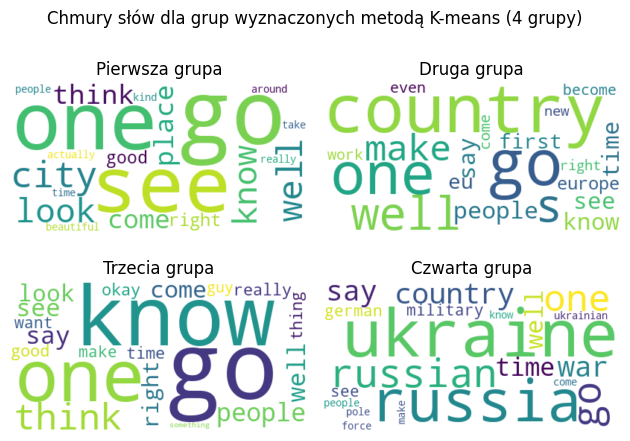

In [127]:
cluster_text_0 = transcripts_kmeans1[transcripts_kmeans1["cluster"] == 0]["text"]
cluster_text_0 = ' '.join(cluster_text_0)
cluster_text_1 = transcripts_kmeans1[transcripts_kmeans1["cluster"] == 1]["text"]
cluster_text_1 = ' '.join(cluster_text_1)
cluster_text_2 = transcripts_kmeans1[transcripts_kmeans1["cluster"] == 2]["text"]
cluster_text_2 = ' '.join(cluster_text_2)
cluster_text_3 = transcripts_kmeans1[transcripts_kmeans1["cluster"] == 3]["text"]
cluster_text_3 = ' '.join(cluster_text_3)

wordcloud_kmeans_0 = WordCloud(background_color="white", max_words=20).generate(cluster_text_0)
wordcloud_kmeans_1 = WordCloud(background_color="white", max_words=20).generate(cluster_text_1)
wordcloud_kmeans_2 = WordCloud(background_color="white", max_words=20).generate(cluster_text_2)
wordcloud_kmeans_3 = WordCloud(background_color="white", max_words=20).generate(cluster_text_3)


plt.subplot(2, 2, 1)
plt.imshow(wordcloud_kmeans_0, interpolation="bilinear")
plt.title("Pierwsza grupa")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(wordcloud_kmeans_1, interpolation="bilinear")
plt.title("Druga grupa")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(wordcloud_kmeans_2, interpolation="bilinear")
plt.title("Trzecia grupa")
plt.axis('off')


plt.subplot(2, 2, 4)
plt.imshow(wordcloud_kmeans_3, interpolation="bilinear")
plt.title("Czwarta grupa")
plt.axis('off')

plt.suptitle("Chmury słów dla grup wyznaczonych metodą K-means (4 grupy)")
plt.tight_layout()
plt.show()


In [128]:
print("Liczba filmów oznaczonych jako grupa pierwsza: ", (transcripts_kmeans1["cluster"] == 0).sum())
print("Liczba filmów oznaczonych jako grupa druga: ", (transcripts_kmeans1["cluster"] == 1).sum())
print("Liczba filmów oznaczonych jako grupa trzecia: ", (transcripts_kmeans1["cluster"] == 2).sum())
print("Liczba filmów oznaczonych jako grupa czwarta: ", (transcripts_kmeans1["cluster"] == 3).sum())

Liczba filmów oznaczonych jako grupa pierwsza:  107
Liczba filmów oznaczonych jako grupa druga:  71
Liczba filmów oznaczonych jako grupa trzecia:  112
Liczba filmów oznaczonych jako grupa czwarta:  86


Interpretacja:
<hr>

Pierwsza grupa może obejmować filmy związane z przemieszczaniem się, zwiedzaniem miast i podziwianiem oraz refleksji na ich temat. Grupa ta na wykresie wykazywała podobieństwo do grupy trzeciej, co również obserwuje się w chmurze słów. Pomimo tego, można je rozróżnić, ponieważ trzecia grupa obejmuje bardziej ogólne tematy, być może dotyczące myśli, opinii ludzi i ogólnych spostrzeżeń. Cechą wspólną więc mogą być odczucia oraz opinie lecz na różnych płaszczyznach. 

Druga grupa może dotyczyć relacji międzynarodowych, konfliktów, sytuacji geopolitycznej, zwłaszcza związanej z Ukrainą, Rosją i Europą. Tematyka ostatniej tj. 4 grupy wydaje się mieć związek z historią Polski, polityką europejską, wojnami i ogólną sytuacją kraju. Na wykresie obserwowano sąsiedztwo tych grup, a na jednej płaszczyźnie przenikały się, potwierdzają to również chmury słów.

<hr>

b. 2 grupy

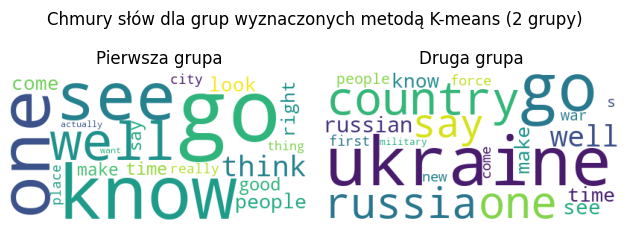

In [129]:
cluster_text_0 = transcripts_kmeans2[transcripts_kmeans2["cluster"] == 0]["text"]
cluster_text_0 = ' '.join(cluster_text_0)
cluster_text_1 = transcripts_kmeans2[transcripts_kmeans2["cluster"] == 1]["text"]
cluster_text_1 = ' '.join(cluster_text_1)

wordcloud_kmeans_0 = WordCloud(background_color="white", max_words=20).generate(cluster_text_0)
wordcloud_kmeans_1 = WordCloud(background_color="white", max_words=20).generate(cluster_text_1)

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_kmeans_0)
plt.title("Pierwsza grupa")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_kmeans_1)
plt.title("Druga grupa")
plt.axis('off')

plt.suptitle("Chmury słów dla grup wyznaczonych metodą K-means (2 grupy)", y= 0.75)
plt.tight_layout()
plt.show()

In [130]:
print("Liczba filmów oznaczonych jako grupa pierwsza: ", (transcripts_kmeans2["cluster"] == 0).sum())
print("Liczba filmów oznaczonych jako grupa druga: ", (transcripts_kmeans2["cluster"] == 1).sum())

Liczba filmów oznaczonych jako grupa pierwsza:  236
Liczba filmów oznaczonych jako grupa druga:  140


## LDA

Lda zostanie wykonany dla 2 oraz 4 tematów, a wyniki porównane do wyników uzyskanych za pomocą metody K-means

Przetworzenie tekstu na wektory:

In [131]:
vectorizer_lda = CountVectorizer()
count_vectorizer = vectorizer_lda.fit_transform(transcripts["text"])
count_vectorizer

<376x17147 sparse matrix of type '<class 'numpy.int64'>'
	with 119623 stored elements in Compressed Sparse Row format>

Wymiar jest taki sam jak w przypadku przygtowywania macierzy tf-idf więc zakładam ze jest utworozny poprawnue

In [132]:
matrix_lda = count_vectorizer.toarray()
matrix_lda = pd.DataFrame(matrix_lda)
feature_names = vectorizer_lda.get_feature_names_out()
matrix_lda.columns = feauter_names
matrix_lda

,aani,abalone,abandon,abandoned,abbas,abbot,abbott,abbreviation,abby,abc,...,świętokrzyskie,šiauliai,żabka,żaneta,żapka,żeligowski,żółkiewski,аnd,водка,еven
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


a. 4 wymiary

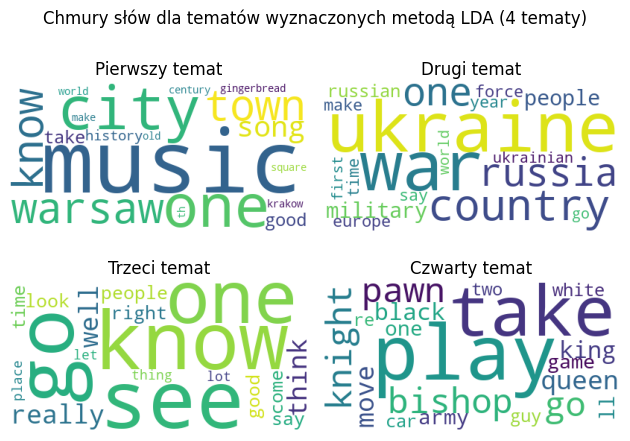

In [137]:
lda = LatentDirichletAllocation(n_components=4, random_state=0)
topics = lda.fit_transform(count_vectorizer)

transcripts_lda1 = transcripts.copy() 
transcripts_lda1["Temat 1"] = topics[:,0]
transcripts_lda1["Temat 2"] = topics[:,1]
transcripts_lda1["Temat 3"] = topics[:,2]
transcripts_lda1["Temat 4"] = topics[:,3]

importance_words_1 = lda.components_[0] #waznosci slow dla pierwszego tematu
index_words_1 = list(range(len(importance_words_1)))
sorted_index_1 = sorted(index_words_1, key=lambda x: importance_words_1[x], reverse=True)
top_index_1 = sorted_index_1[:20] #wybór 20 najwazniejszych
top_words_1 = [feature_names[i] for i in top_index_1]

importance_words_2 = lda.components_[1]
index_words_2 = list(range(len(importance_words_2)))
sorted_index_2 = sorted(index_words_2, key=lambda x: importance_words_2[x], reverse=True)
top_index_2 = sorted_index_2[:20] 
top_words_2 = [feature_names[i] for i in top_index_2]

importance_words_3 = lda.components_[2] 
index_words_3 = list(range(len(importance_words_3)))
sorted_index_3 = sorted(index_words_3, key=lambda x: importance_words_3[x], reverse=True)
top_index_3 = sorted_index_3[:20] 
top_words_3 = [feature_names[i] for i in top_index_3]

importance_words_4 = lda.components_[3] 
index_words_4 = list(range(len(importance_words_4)))
sorted_index_4 = sorted(index_words_4, key=lambda x: importance_words_4[x], reverse=True)
top_index_4 = sorted_index_4[:20] 
top_words_4 = [feature_names[i] for i in top_index_4]


wordcloud_lda_1 = WordCloud(background_color='white').generate(' '.join(top_words_1))
wordcloud_lda_2 = WordCloud(background_color='white').generate(' '.join(top_words_2))
wordcloud_lda_3 = WordCloud(background_color='white').generate(' '.join(top_words_3))
wordcloud_lda_4 = WordCloud(background_color='white').generate(' '.join(top_words_4))


plt.subplot(2, 2, 1)
plt.imshow(wordcloud_lda_1)
plt.axis('off')
plt.title('Pierwszy temat')

plt.subplot(2, 2, 2)
plt.imshow(wordcloud_lda_2)
plt.axis('off')
plt.title('Drugi temat')

plt.subplot(2, 2, 3)
plt.imshow(wordcloud_lda_3)
plt.axis('off')
plt.title('Trzeci temat')

plt.subplot(2, 2, 4)
plt.imshow(wordcloud_lda_4)
plt.axis('off')
plt.title('Czwarty temat')

plt.suptitle("Chmury słów dla tematów wyznaczonych metodą LDA (4 tematy)")
plt.tight_layout()
plt.show()

In [138]:
count_topic_1 = len(transcripts_lda1[transcripts_lda1["Temat 1"] > 0.5])
count_topic_2 = len(transcripts_lda1[transcripts_lda1["Temat 2"] > 0.5])
count_topic_3 = len(transcripts_lda1[transcripts_lda1["Temat 3"] > 0.5])
count_topic_4 = len(transcripts_lda1[transcripts_lda1["Temat 4"] > 0.5])

print(f"Ilość filmów przynależnych do tematu 1: {count_topic_1}")
print(f"Ilość filmów przynależnych do tematu 2: {count_topic_2}")
print(f"Ilość filmów przynależnych do tematu 3: {count_topic_3}")
print(f"Ilość filmów przynależnych do tematu 4: {count_topic_4}")

Ilość filmów przynależnych do tematu 1: 36
Ilość filmów przynależnych do tematu 2: 125
Ilość filmów przynależnych do tematu 3: 178
Ilość filmów przynależnych do tematu 4: 16


Interpretacja:
<hr>

Można zauważyć, że chmury słów dla tematów wykonanych metodą LDA są podobne do grup wyłonionych metodą K-means. Pomimo pewnych różnic w konkretnych słowach kluczowych, obserwuje się, że oba modele sugerują pewne podobieństwa tematyczne, takie jak kwestie związane z Europą, historią, wojną, podróżami i ogólnymi tematami życia codziennego. 

Temat pierwszy można porównać do grupy drugiej, obie chmury wskazują na tematykę związana z Ukrainą, Rosją, wojną i sytuacją geopolityczną w Europie. Jednak temat LDA skupia się bardziej na wojnie i aspektach militarnych, podczas gdy grupa K-means uwzględnia także aspekty polityki europejskiej.

Temat drugi wykazuje silne podobieństwo do grupy czwartej. Obie chmury reprezentujące modele sugerują zainteresowanie Europą i krajami, lecz temat LDA skupia się na ogólnych aspektach historii, wojen i związków międzynarodowych, podczas gdy grupa K-means zawiera konkretne słowa związane z krajami europejskimi.

Zarówno temat trzeci jak i grupa pierwsza K-means zawierają słowa związane z ogólnymi tematami, takimi jak ludzie, myśli, dobre uczucia, itp.

Natomiast temat 4 można porównać do grupy trzeciej K-means, która podobnie obejmuje słowa związane z podróżami, miejscami, spojrzeniem i ogólnymi tematami.

Należy zwrócić uwagę, że tematy wyłonione metodą LDA pomimo podobieństw są bardziej indywidualne aniżeli grupy powstałe w wyniku grupowania K-means.

<hr>

b. 2 wymiary

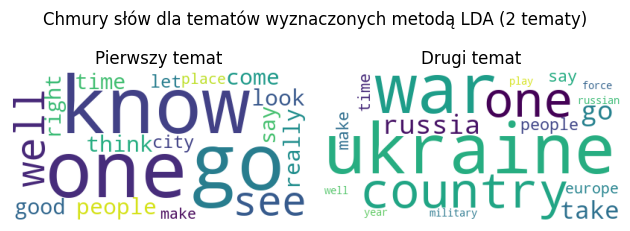

In [139]:
lda = LatentDirichletAllocation(n_components=2, random_state=0)
topics = lda.fit_transform(count_vectorizer)

transcripts_lda2 = transcripts.copy() 
transcripts_lda2["Temat 1"] = topics[:,0]
transcripts_lda2["Temat 2"] = topics[:,1]

importance_words_1 = lda.components_[0] #waznosci slow dla pierwszego tematu
index_words_1 = list(range(len(importance_words_1)))
sorted_index_1 = sorted(index_words_1, key=lambda x: importance_words_1[x], reverse=True)
top_index_1 = sorted_index_1[:20] #wybór 10 najwazniejszych
top_words_1 = [feature_names[i] for i in top_index_1]

importance_words_2 = lda.components_[1] #waznosci slow dla drugiego tematu
index_words_2 = list(range(len(importance_words_2)))
sorted_index_2 = sorted(index_words_2, key=lambda x: importance_words_2[x], reverse=True)
top_index_2 = sorted_index_2[:20] 
top_words_2 = [feature_names[i] for i in top_index_2]


wordcloud_lda_1 = WordCloud(background_color='white').generate(' '.join(top_words_1))
wordcloud_lda_2 = WordCloud(background_color='white').generate(' '.join(top_words_2))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_lda_1)
plt.axis('off')
plt.title('Pierwszy temat')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_lda_2)
plt.axis('off')
plt.title('Drugi temat')

plt.suptitle("Chmury słów dla tematów wyznaczonych metodą LDA (2 tematy)", y= 0.75)
plt.tight_layout()
plt.show()

In [142]:
count_topic_1 = len(transcripts_lda2[transcripts_lda2["Temat 1"] > 0.5])
count_topic_2 = len(transcripts_lda2[transcripts_lda2["Temat 2"] > 0.5])

print(f"Ilość filmów przynależnych do tematu 1: {count_topic_1}")
print(f"Ilość filmów przynależnych do tematu 2: {count_topic_2}")

Ilość filmów przynależnych do tematu 1: 217
Ilość filmów przynależnych do tematu 2: 159


<hr>

# Analiza sentymentu

### Sprawdzenie najpopularniejszych wśród widzów kategorii (stara hipoteza)

### Analiza sentymentu w kategoriach "News & Politics" i "Travel & Events" (nowa hipoteza)

#### a. News & Politics

W tej analizie wróćmy do wszystkich filmów

In [143]:
sentiment_data_news = data_cat[data_cat["Kategorie filmu"] == "News & Politics"] #uzywam tabeli data_cat a nie all_transcripts_clustering poniewaz chce wziąć pod uwagę wszystkie filmy, nie tylko rowne badz dluzsze 3 minuty
sentiment_data_news = sentiment_data_news.loc[:, ["Transkrypcja oczyszczona"]].rename(columns={"Transkrypcja oczyszczona": "text"})
print(sentiment_data_news.size)
sentiment_data_news.head()

79


,text
12,september th lockheed martin maker famous hima...
18,come lot get intense focus israelgaza war amer...
19,sustain ukraine critical make sure happen pres...
20,president andre duda thank much join bloomberg...
23,welcome hungary member european union two deca...


### Analiza sentymentu za pomocą vader z nltk 

In [144]:
def sentiment_vader_function(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

sentiment_vader = sentiment_data_news.copy()
sentiment_vader["sentiment"] = sentiment_vader["text"].apply(sentiment_vader_function)

sentiment_vader["compound"] = sentiment_vader["sentiment"].apply(lambda x: x['compound'])
sentiment_vader["positive"] = sentiment_vader["sentiment"].apply(lambda x: x['pos'])
sentiment_vader["neutral"] = sentiment_vader["sentiment"].apply(lambda x: x['neu'])
sentiment_vader["negative"] = sentiment_vader["sentiment"].apply(lambda x: x['neg'])

sentiment_vader

,text,sentiment,compound,positive,neutral,negative
12,september th lockheed martin maker famous hima...,"{'neg': 0.054, 'neu': 0.788, 'pos': 0.158, 'co...",0.9966,0.158,0.788,0.054
18,come lot get intense focus israelgaza war amer...,"{'neg': 0.078, 'neu': 0.652, 'pos': 0.269, 'co...",0.9911,0.269,0.652,0.078
19,sustain ukraine critical make sure happen pres...,"{'neg': 0.1, 'neu': 0.633, 'pos': 0.267, 'comp...",0.9968,0.267,0.633,0.100
20,president andre duda thank much join bloomberg...,"{'neg': 0.093, 'neu': 0.627, 'pos': 0.281, 'co...",0.9997,0.281,0.627,0.093
23,welcome hungary member european union two deca...,"{'neg': 0.074, 'neu': 0.751, 'pos': 0.176, 'co...",0.9964,0.176,0.751,0.074
...,...,...,...,...,...,...
443,stop kill stop kill doubt pro – right live fou...,"{'neg': 0.32, 'neu': 0.496, 'pos': 0.184, 'com...",-0.9972,0.184,0.496,0.320
444,happen side nicole absolutely robert continue ...,"{'neg': 0.085, 'neu': 0.752, 'pos': 0.163, 'co...",0.9514,0.163,0.752,0.085
450,many refugee take zero proud ask muslims illeg...,"{'neg': 0.297, 'neu': 0.453, 'pos': 0.25, 'com...",-0.7184,0.250,0.453,0.297
463,dutch voter hand farright landslide victory po...,"{'neg': 0.103, 'neu': 0.639, 'pos': 0.258, 'co...",0.9940,0.258,0.639,0.103


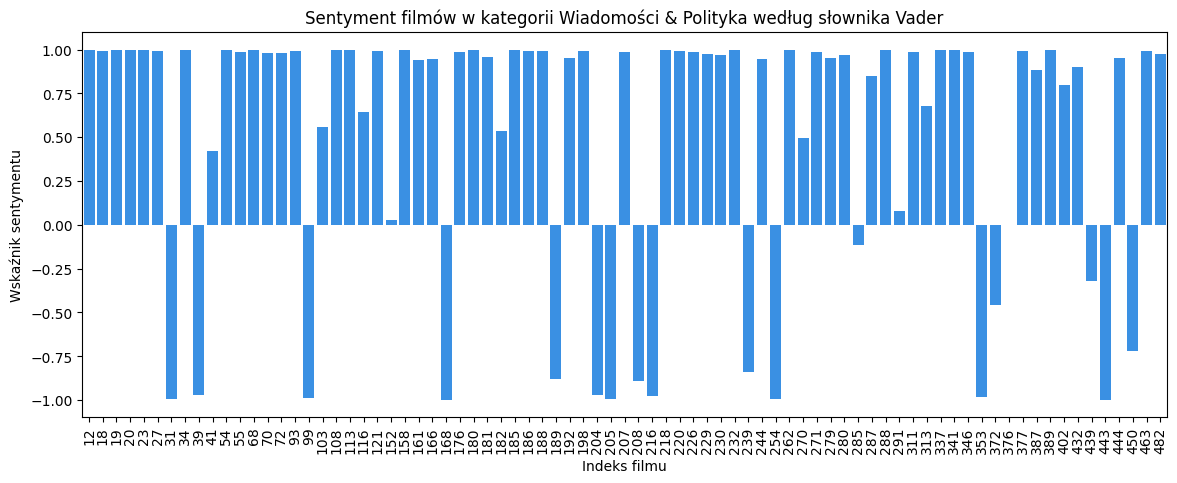

In [145]:
plt.figure(figsize=(14, 5))
sns.barplot(x=sentiment_vader.index, y="compound", data=sentiment_vader, color="dodgerblue")
plt.title("Sentyment filmów w kategorii Wiadomości & Polityka według słownika Vader")
plt.xlabel("Indeks filmu")
plt.ylabel("Wskaźnik sentymentu")
plt.xticks(rotation = 90)
plt.show()

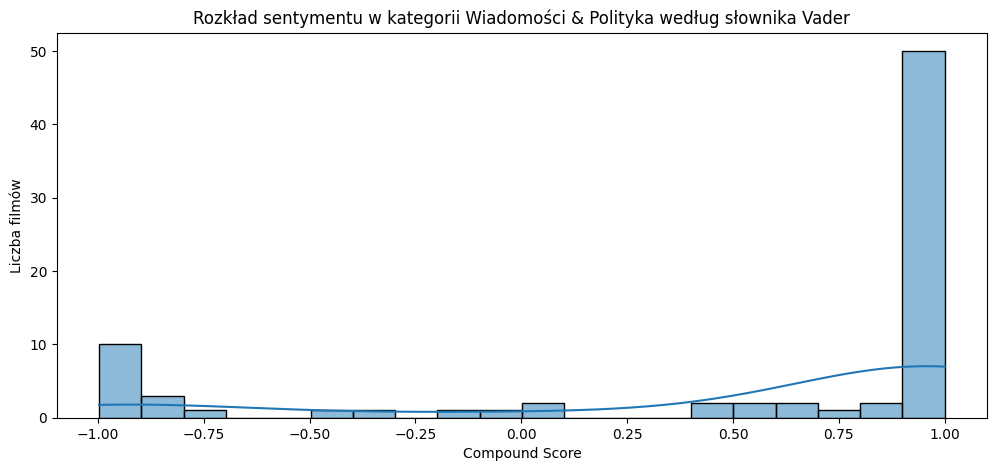

In [217]:
plt.figure(figsize=(12, 5))
sns.histplot(sentiment_vader["compound"], bins=20, kde = True)
plt.title('Rozkład sentymentu w kategorii Wiadomości & Polityka według słownika Vader')
plt.xlabel('Compound Score')
plt.ylabel('Liczba filmów')
plt.show()

Analiza sentymentu według pierwszej metody zdaje się być nieudana, przynajmniej w kwestii intensywności sentymentów (głównie mocno pozytywne, bądź mocno negatywne) co wydaje się nie odzwierciedlać dobrze rzeczywistości. Pomimo tego można wyciągnąć wniosek, że w treściach filmów z kategorii wiadomości i polityka przeważa pozytywny sentyment.


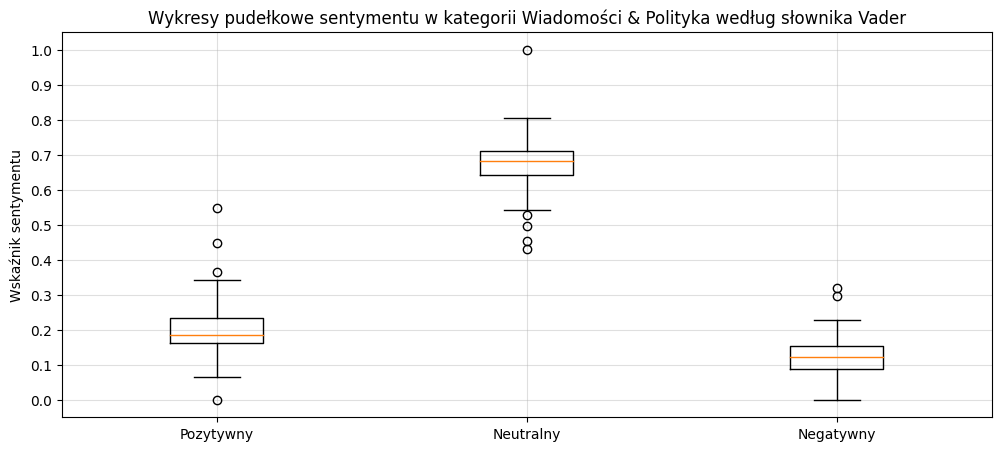

In [218]:
plt.figure(figsize=(12, 5))

plt.boxplot([sentiment_vader["positive"], sentiment_vader["neutral"], sentiment_vader["negative"]], labels=["Pozytywny", "Neutralny", "Negatywny"])
plt.title("Wykresy pudełkowe sentymentu w kategorii Wiadomości & Polityka według słownika Vader")
plt.ylabel("Wskaźnik sentymentu")
plt.grid(alpha = 0.4)
plt.yticks([i/10 for i in range(11)])
plt.show()

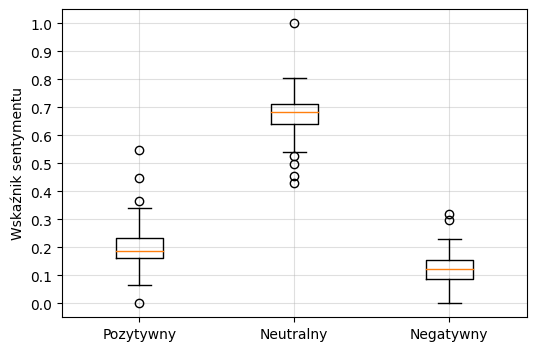

In [219]:
plt.figure(figsize=(6, 4))

plt.boxplot([sentiment_vader["positive"], sentiment_vader["neutral"], sentiment_vader["negative"]], labels=["Pozytywny", "Neutralny", "Negatywny"])
plt.ylabel("Wskaźnik sentymentu")
plt.grid(alpha = 0.4)
plt.yticks([i/10 for i in range(11)])
plt.show()

Można zauważyć ze transkrypcje filmów w kategorii wiadomości i polityka skupiają się najbardziej na wartościach neutralnych. Ponadto obserwuje się przewagę sentymentu pozytywnego nad negatywnym. Podczas gdy mediana wskaźnika dla neutralnego sentymentu dla transkrypcji filmów na YouTube związanych z tematyką Polski osiąga niecałe 0.7, mediana wskaźnika pozytywnego osiąga lekko poniżej 0.2, natomiast mediana wskaźnika negatywnego w okolicy 0.15.

### Analiza sentymentu za pomocą TextBlob

In [ ]:
def sentiment_textblob_function(text):
    sentiment = TextBlob(text)
    return sentiment.polarity

sentiment_textblob = sentiment_data_news.copy()
sentiment_textblob["sentiment"] = sentiment_textblob["text"].apply(sentiment_textblob_function)
sentiment_textblob.head()

,text,sentiment
12,september th lockheed martin maker famous hima...,0.084785
18,come lot get intense focus israelgaza war amer...,0.147321
19,sustain ukraine critical make sure happen pres...,0.151959
20,president andre duda thank much join bloomberg...,0.168219
23,welcome hungary member europe union two decade...,0.107982


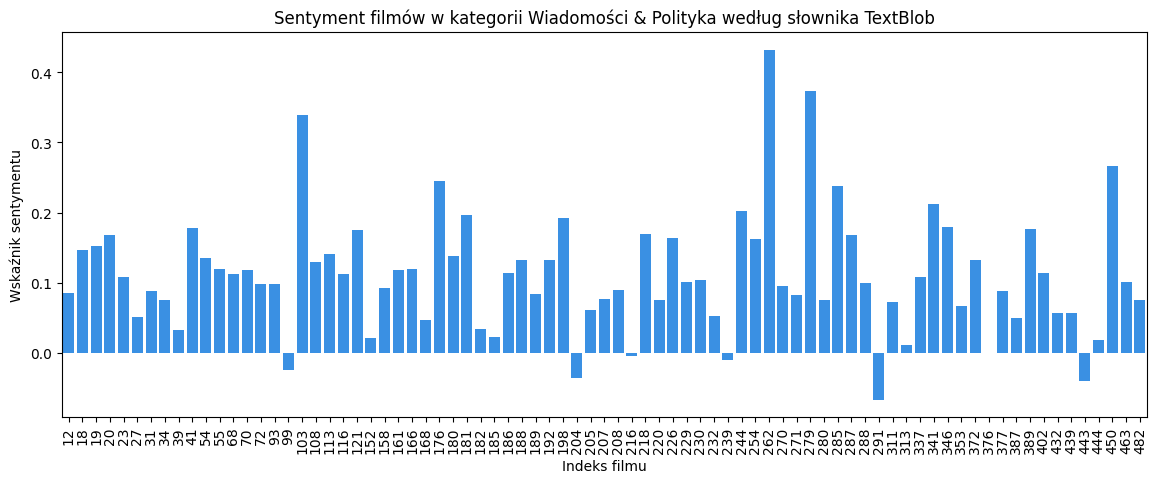

In [ ]:
plt.figure(figsize=(14, 5))
sns.barplot(x=sentiment_textblob.index, y="sentiment", data=sentiment_textblob, color="dodgerblue")
plt.title("Sentyment filmów w kategorii Wiadomości & Polityka według słownika TextBlob")
plt.xlabel("Indeks filmu")
plt.ylabel("Wskaźnik sentymentu")
plt.xticks(rotation = 90)
plt.show()

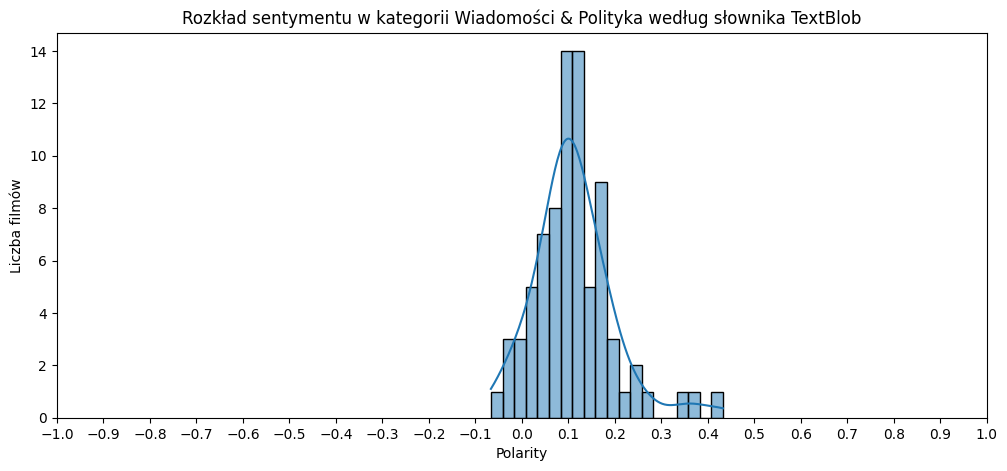

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(sentiment_textblob["sentiment"], bins=20, kde=True)
plt.title('Rozkład sentymentu w kategorii Wiadomości & Polityka według słownika TextBlob')
plt.xlabel('Polarity')
plt.ylabel('Liczba filmów')
plt.xticks([i/10 for i in range(-10, 11)])
plt.show()

Analiza sentymentu według TextBlob wydaje się dawać bardziej miarodajne wyniki, sentyment waha się w granicach -0.5 – 0.45 dla poszczególnych filmów. 
Możemy zaobserwować ze histogram sentymentu w tej kategorii znajduje się w większości po prawej ('pozytywnej') stronie, z szczytem na poziomie około 0.1, co oznacza, że najwięcej filmów uzyskało taki właśnie wynik. Czterem filmom został przypisany ogólny negatywny sentyment.


#### b. Travel & Events

In [ ]:
sentiment_data_travel = data_cat[data_cat["Kategorie filmu"] == "Travel & Events"] #uzywam tabeli data_cat a nie all_transcripts_clustering poniewaz chce wziąć pod uwagę wszystkie filmy, nie tylko rowne badz dluzsze 3 minuty
sentiment_data_travel = sentiment_data_travel.loc[:, ["Transkrypcja oczyszczona"]].rename(columns={"Transkrypcja oczyszczona": "text"})
print(sentiment_data_travel.size)
sentiment_data_travel.head()

101


,text
6,love independence day city color everybodys li...
7,good go guy welcome gdansk super excited hear ...
8,good good evening uba uba żaneta welcome chann...
9,one thing sure trip never bore thank incredibl...
10,thank music good welcome krakow welcome first ...


### Analiza sentymentu za pomocą vader z nltk 

In [ ]:
def sentiment_vader_function(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

sentiment_vader = sentiment_data_travel.copy()
sentiment_vader["sentiment"] = sentiment_vader["text"].apply(sentiment_vader_function)

sentiment_vader["compound"] = sentiment_vader["sentiment"].apply(lambda x: x['compound'])
sentiment_vader["positive"] = sentiment_vader["sentiment"].apply(lambda x: x['pos'])
sentiment_vader["neutral"] = sentiment_vader["sentiment"].apply(lambda x: x['neu'])
sentiment_vader["negative"] = sentiment_vader["sentiment"].apply(lambda x: x['neg'])

sentiment_vader

,text,sentiment,compound,positive,neutral,negative
6,love independence day city color everybodys li...,"{'neg': 0.034, 'neu': 0.723, 'pos': 0.243, 'co...",0.9977,0.243,0.723,0.034
7,good go guy welcome gdansk super excited hear ...,"{'neg': 0.053, 'neu': 0.565, 'pos': 0.382, 'co...",0.9999,0.382,0.565,0.053
8,good good evening uba uba żaneta welcome chann...,"{'neg': 0.048, 'neu': 0.633, 'pos': 0.319, 'co...",0.9996,0.319,0.633,0.048
9,one thing sure trip never bore thank incredibl...,"{'neg': 0.068, 'neu': 0.703, 'pos': 0.229, 'co...",0.9994,0.229,0.703,0.068
10,thank music good welcome krakow welcome first ...,"{'neg': 0.033, 'neu': 0.561, 'pos': 0.406, 'co...",0.9997,0.406,0.561,0.033
...,...,...,...,...,...,...
489,let show around last trip start visit goniadz ...,"{'neg': 0.103, 'neu': 0.765, 'pos': 0.132, 'co...",0.7923,0.132,0.765,0.103
492,hey travel buddy kat cezary one kiwicom world ...,"{'neg': 0.022, 'neu': 0.834, 'pos': 0.143, 'co...",0.9862,0.143,0.834,0.022
493,go bad vlog life know love bread thing thing c...,"{'neg': 0.088, 'neu': 0.584, 'pos': 0.328, 'co...",0.9998,0.328,0.584,0.088
494,hello friend video cross border terespol brest...,"{'neg': 0.064, 'neu': 0.694, 'pos': 0.241, 'co...",0.9902,0.241,0.694,0.064


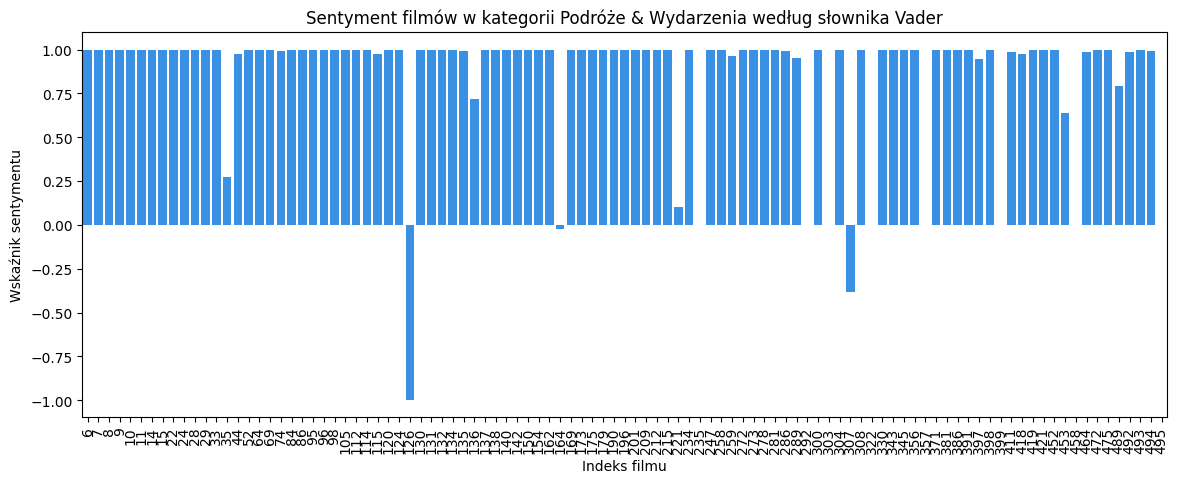

In [ ]:
plt.figure(figsize=(14, 5))
sns.barplot(x=sentiment_vader.index, y="compound", data=sentiment_vader, color="dodgerblue")
plt.title("Sentyment filmów w kategorii Podróże & Wydarzenia według słownika Vader")
plt.xlabel("Indeks filmu")
plt.ylabel("Wskaźnik sentymentu")
plt.xticks(rotation = 90)
plt.show()

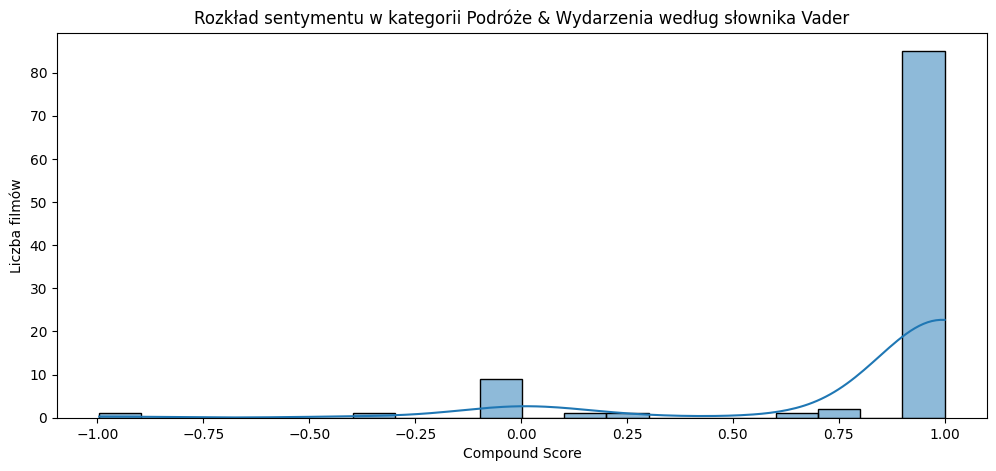

In [ ]:
plt.figure(figsize=(12,5))
sns.histplot(sentiment_vader["compound"], bins=20, kde = True)
plt.title('Rozkład sentymentu w kategorii Podróże & Wydarzenia według słownika Vader')
plt.xlabel('Compound Score')
plt.ylabel('Liczba filmów')
plt.show()

Analiza sentymentu według pierwszej metody zdaje się być również nieudana, przynajmniej w kwestii intensywności sentymentów (głównie mocno pozytywne, bądź mocno negatywne) co wydaje się nie odzwierciedlać dobrze rzeczywistości. Pomimo tego można wyciągnąć wniosek, że w treściach filmów z kategorii wiadomości i polityka zdecydowanie przeważa pozytywny sentyment.

Pomimo tego mozna wyciagnąć wniosek, ze w treściach filmów z kategorii Travel & Events góruje pozytywny sentyment. 

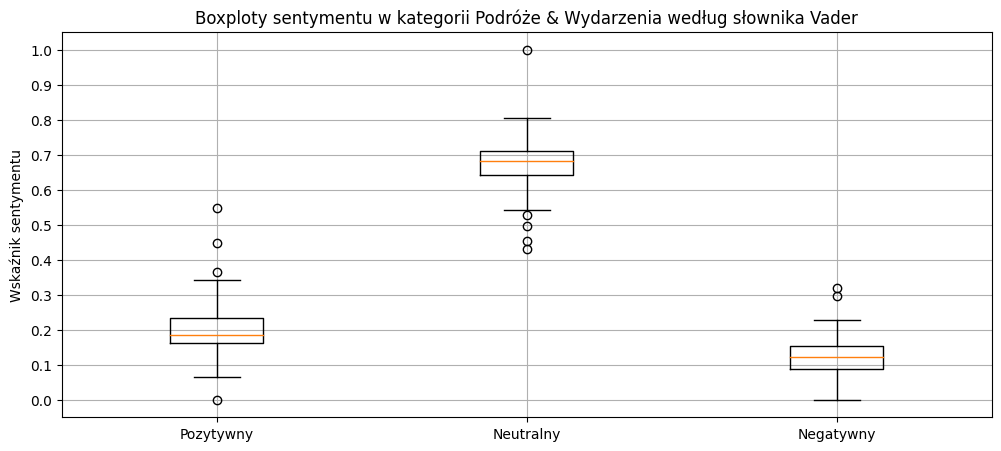

In [220]:
plt.figure(figsize=(12, 5))

plt.boxplot([sentiment_vader["positive"], sentiment_vader["neutral"], sentiment_vader["negative"]], labels=["Pozytywny", "Neutralny", "Negatywny"])
plt.title("Boxploty sentymentu w kategorii Podróże & Wydarzenia według słownika Vader")
plt.ylabel("Wskaźnik sentymentu")
plt.grid()
plt.yticks([i/10 for i in range(11)])
plt.show()

Można zauważyć ze transkrypcje filmów w kategorii podróże i wiadomości również skupiają się najbardziej na wartościach neutralnych. Ponadto obserwuje się przewagę sentymentu pozytywnego nad negatywnym. Podczas gdy mediana wskaźnika dla neutralnego sentymentu dla transkrypcji filmów na YouTube związanych z tematyką Polski osiąga niecałe 0.7, mediana wskaźnika pozytywnego osiąga lekko poniżej 0.3, natomiast mediana wskaźnika negatywnego poniżej 1

### Analiza sentymentu za pomocą TextBlob

In [ ]:
def sentiment_textblob_function(text):
    sentiment = TextBlob(text)
    return sentiment.polarity

sentiment_textblob = sentiment_data_travel.copy()
sentiment_textblob["sentiment"] = sentiment_textblob["text"].apply(sentiment_textblob_function)
sentiment_textblob.head()

,text,sentiment
6,love independence day city color everybodys li...,0.132377
7,good go guy welcome gdansk super excited hear ...,0.259563
8,good good evening uba uba żaneta welcome chann...,0.228277
9,one thing sure trip never bore thank incredibl...,0.328686
10,thank music good welcome krakow welcome first ...,0.341858


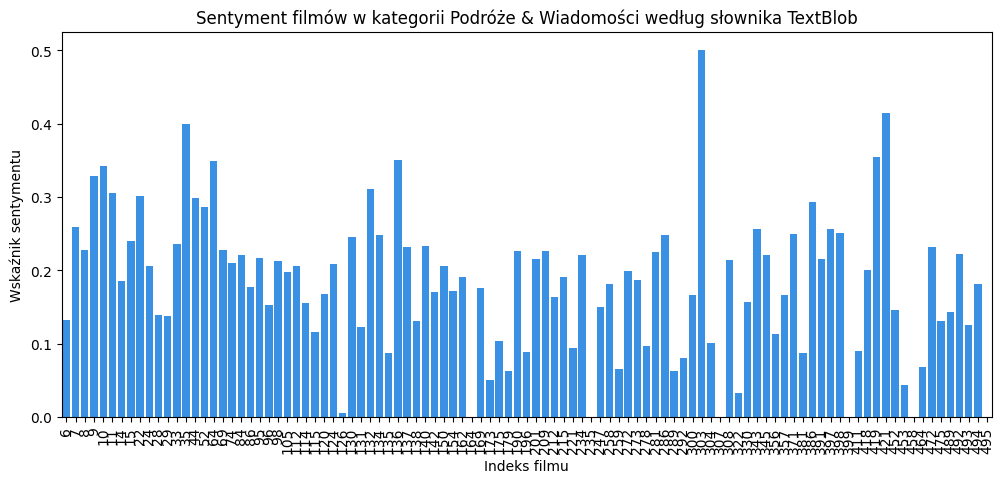

In [ ]:
plt.figure(figsize=(12, 5))
sns.barplot(x=sentiment_textblob.index, y="sentiment", data=sentiment_textblob, color="dodgerblue")
plt.title("Sentyment filmów w kategorii Podróże & Wiadomości według słownika TextBlob")
plt.xlabel("Indeks filmu")
plt.ylabel("Wskaźnik sentymentu")
plt.xticks(rotation = 90)
plt.show()


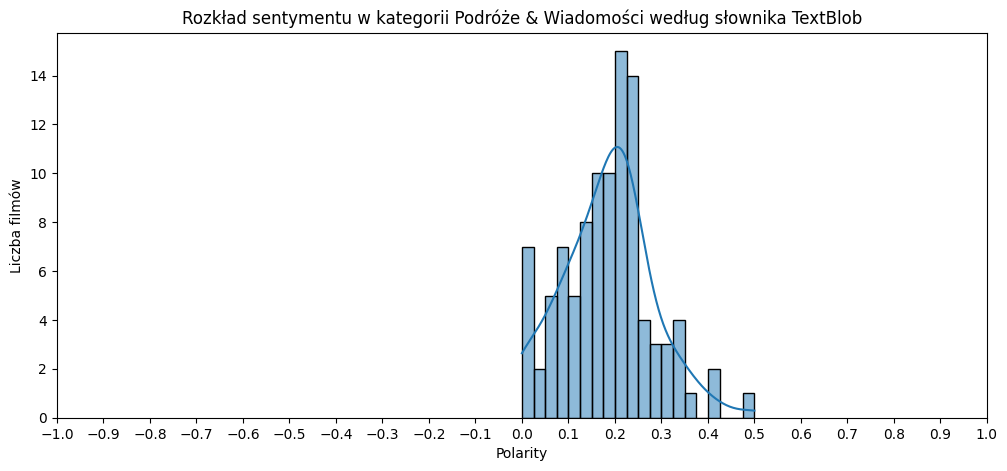

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(sentiment_textblob["sentiment"], bins=20, kde=True)
plt.title('Rozkład sentymentu w kategorii Podróże & Wiadomości według słownika TextBlob')
plt.xlabel('Polarity')
plt.ylabel('Liczba filmów')
plt.xticks([i/10 for i in range(-10, 11)])
plt.show()

Analiza sentymentu według TextBlob bardziej osiąga bardziej miarodajne wyniki aniżeli według biblioteki NLTK. Sentyment waha się w granicach 0 – 0.5 dla poszczególnych filmów. 
Możemy zaobserwować ze histogram sentymentu w tej kategorii znajduje się po prawej ('pozytywnej') stronie, z szczytem na poziomie około 0.2, co oznacza, że najwięcej filmów uzyskało taki właśnie wynik. Żadnym filmom nie został przypisany ogólny negatywny sentyment.


<hr>

UWAGA! Nalezy zwrócić uwagę, ze jest to ogólny wskaźnik sentymentu dla filmów - niektórych krótszych, niektórych dłuzszych, ma to swoje konsekwencje w duzych granicach błędu. Przykładowo długie filmy o ogólnym wskaźniku pozytywnym, mogą tak naprawdę mieć duzo negatywncyh treści ale z przewagą pozytywnych. Minusem takeigo ogólnego wskaźnika jest fakt, źe nie moźna spawdzić dynamiki wypowiedzi, jednak ta analiza miała sprawdzić ogólne nacechowanie treści filmów związanych z tematyką Polski w wybranych kategoriach. 

W tym celu wyniki uzytych technik dają jasną odpowiedź: treści filmów z kategorii news & politics oraz travel & events są nacechowane pozytywnie, chodź zdarzają się negatywne lecz w bardzo małych ilościach szczególnie w drugiej z wymienionych kategorii

<hr>

## Analiza sentymentu treści kanałów telewizyjnych z kategorii news & politics

W drodzę eksploracji zauwazono, ze 3 na 4 kanały udostępniające filmy w rankingu top 4 (pod względem liczby udostępnionych filmów w naszej bazie) to kanały stacji telewizyjnych:

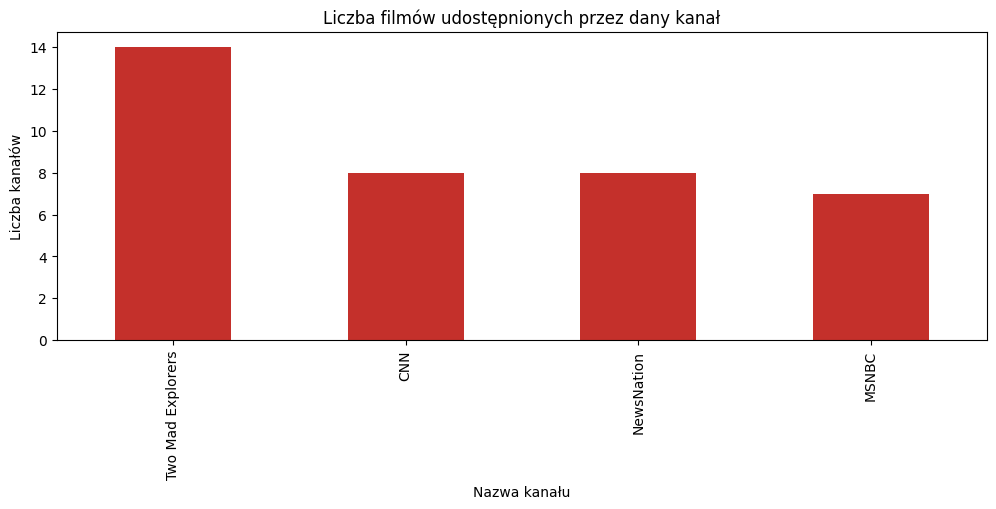

In [ ]:
plt.figure(figsize=(12, 4))
data_cat['Nazwa kanalu'].value_counts().head(4).plot(kind='bar', color ="#c4302b")
plt.title('Liczba filmów udostępnionych przez dany kanał')
plt.xlabel('Nazwa kanału')
plt.ylabel('Liczba kanałów')
plt.show()

Są to: CNN, NewsNation oraz MSNBC. Co ciekawe, wszytskie 3 są Amerykańskie. <br>
Sprawdźmy o jakich kategoriach dane kanały udostępniły filmy:

In [ ]:
print("CNN: ", data_cat[data_cat["Nazwa kanalu"] == "CNN"]["Kategorie filmu"].value_counts())
print("NewsNation: ", data_cat[data_cat["Nazwa kanalu"] == "NewsNation"]["Kategorie filmu"].value_counts())
print("MSNBC: ", data_cat[data_cat["Nazwa kanalu"] == "MSNBC"]["Kategorie filmu"].value_counts())

CNN:  News & Politics    8
Name: Kategorie filmu, dtype: int64
NewsNation:  News & Politics    8
Name: Kategorie filmu, dtype: int64
MSNBC:  News & Politics    7
Name: Kategorie filmu, dtype: int64


Wszytskie kanały udostępniły filmy o kategorii news & politics. Następnie mozna sprawdzic ogólny wskaźnik sentymentu dla kazdego kanału aby sprawdzić, który kanał wypowiada się najpozytywniej/mówi o pozytywnych rzeczach na tematy związane z Polską

Przygotowanie danych:

In [ ]:
sentiment_data_channels_CNN = data_cat[data_cat["Nazwa kanalu"] == "CNN"]
sentiment_data_channels_CNN = sentiment_data_channels_CNN.loc[:, ["Transkrypcja oczyszczona"]].rename(columns={"Transkrypcja oczyszczona": "text"})
print(sentiment_data_channels_CNN.size)
sentiment_data_channels_CNN.head()

8


,text
27,join marek magierowski ambassador united state...
93,late strike come amid dramatic downward spiral...
121,h president duda warsaw go talk support ukrain...
161,united nationsefugee agency estimate around u...
226,phil black cnn estonia us soldier officially w...


In [ ]:
sentiment_data_channels_NewsNation = data_cat[data_cat["Nazwa kanalu"] == "NewsNation"]
sentiment_data_channels_NewsNation = sentiment_data_channels_NewsNation.loc[:, ["Transkrypcja oczyszczona"]].rename(columns={"Transkrypcja oczyszczona": "text"})
print(sentiment_data_channels_NewsNation.size)
sentiment_data_channels_NewsNation.head()

8


,text
204,likely face illegal reentry well nicole hopefu...
271,expulsion washington diplomat russia berg form...
313,play year back war ukraine although reject imp...
341,turkey pie man woman service overseas gather c...
346,slovakia beyonce follow suit adrian right joe ...


In [ ]:
sentiment_data_channels_MSNBC = data_cat[data_cat["Nazwa kanalu"] == "MSNBC"]
sentiment_data_channels_MSNBC = sentiment_data_channels_MSNBC.loc[:, ["Transkrypcja oczyszczona"]].rename(columns={"Transkrypcja oczyszczona": "text"})
print(sentiment_data_channels_MSNBC.size)
sentiment_data_channels_MSNBC.head()

7


,text
18,come lot get intense focus israelgaza war amer...
19,sustain ukraine critical make sure happen pres...
41,source war source war russia change nothing ru...
54,speak congress inspire leadership uk continue ...
192,good evening warsaw good evening warsaw thank ...


Analiza tylko za pomocą TextBlob, poniewaz lepiej radzil sobie z naszą bazą:

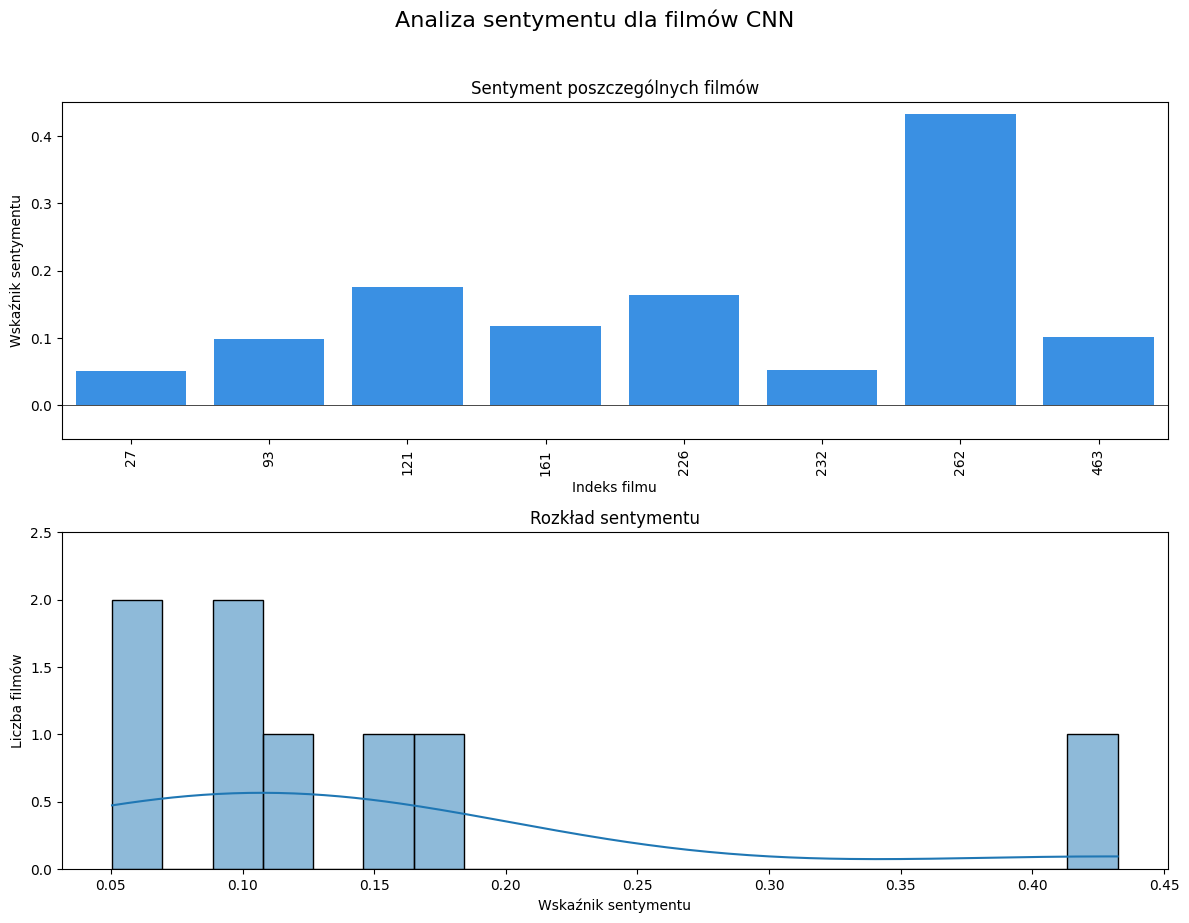

In [ ]:
sentiment_textblob1 = sentiment_data_channels_CNN.copy()
sentiment_textblob1["sentiment"] = sentiment_textblob1["text"].apply(sentiment_textblob_function)

plt.figure(figsize=(12, 9))

plt.subplot(2,1,1)
ax1 = sns.barplot(x=sentiment_textblob1.index, y="sentiment", data=sentiment_textblob1, color="dodgerblue")
plt.title("Sentyment poszczególnych filmów")
plt.xlabel("Indeks filmu")
plt.ylabel("Wskaźnik sentymentu")
plt.xticks(rotation = 90)
plt.ylim(-0.05, 0.45)
ax1.axhline(0, color='black', linestyle='-', linewidth=0.5)

plt.subplot(2,1,2)
sns.histplot(sentiment_textblob1["sentiment"], bins=20, kde = True)
plt.title('Rozkład sentymentu')
plt.xlabel('Wskaźnik sentymentu')
plt.ylabel('Liczba filmów')
plt.ylim(0, 2.5)

plt.suptitle('Analiza sentymentu dla filmów CNN', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()



Wszystkie 8 filmów CNN zostały oznaczone jako pozytywne w drodze analizy sentymentu

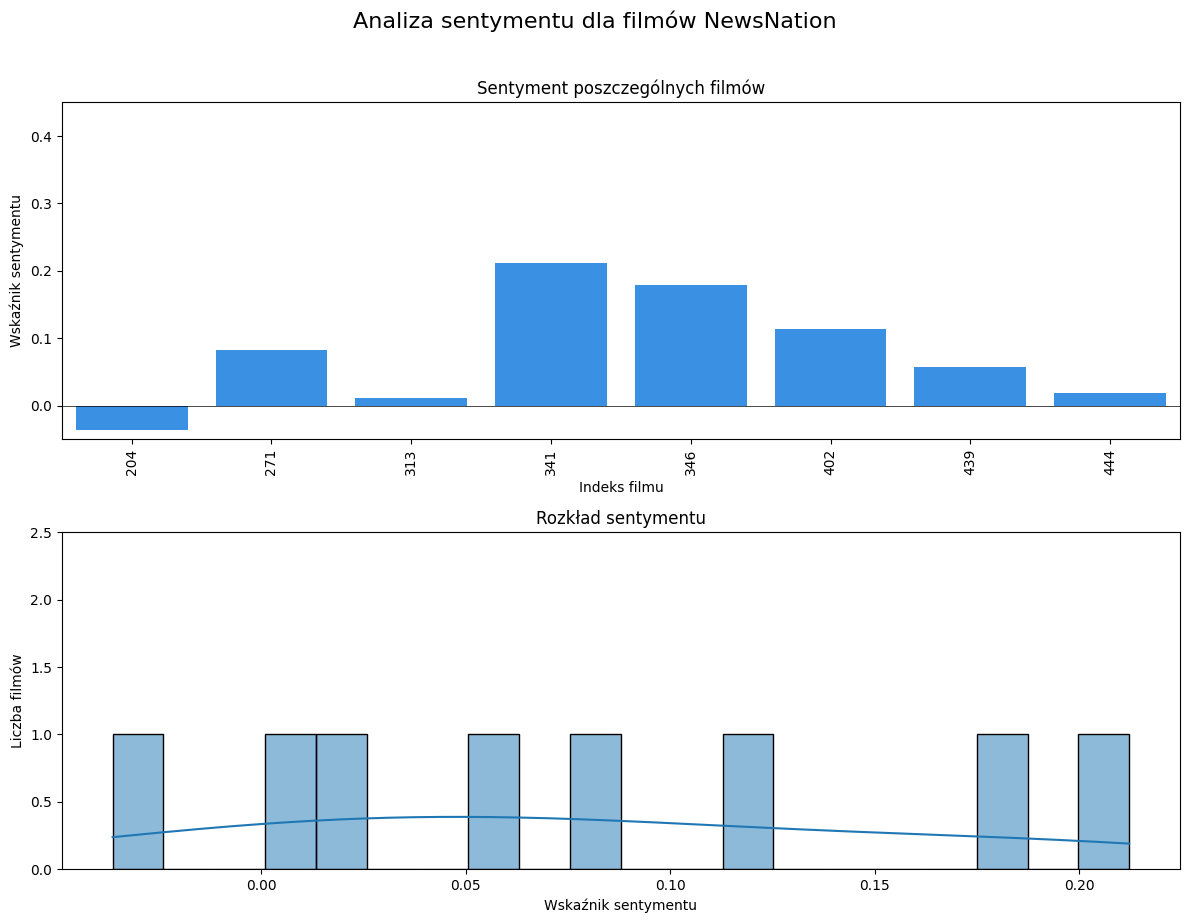

In [ ]:
sentiment_textblob2 = sentiment_data_channels_NewsNation.copy()
sentiment_textblob2["sentiment"] = sentiment_textblob2["text"].apply(sentiment_textblob_function)

plt.figure(figsize=(12, 9))

plt.subplot(2,1,1)
ax1 = sns.barplot(x=sentiment_textblob2.index, y="sentiment", data=sentiment_textblob2, color="dodgerblue")
plt.title("Sentyment poszczególnych filmów")
plt.xlabel("Indeks filmu")
plt.ylabel("Wskaźnik sentymentu")
plt.xticks(rotation = 90)
plt.ylim(-0.05, 0.45)
ax1.axhline(0, color='black', linestyle='-', linewidth=0.5)

plt.subplot(2,1,2)
sns.histplot(sentiment_textblob2["sentiment"], bins=20, kde = True)
plt.title('Rozkład sentymentu')
plt.xlabel('Wskaźnik sentymentu')
plt.ylabel('Liczba filmów')
plt.ylim(0, 2.5)

plt.suptitle('Analiza sentymentu dla filmów NewsNation', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

7/8 filmów NeswNation charakteryzuje się pozytywnym wskaźnikiem sentymentu, jeden film został oznaczony jako negatywny ale wynik jest bardzo bliski 0, przyjrzyjmy się mu blizej:

In [ ]:
print("Tytuł: ",data_cat.loc[204]['Tytuł'])
print("Liczba słow: ",data_cat.loc[204]['Liczba słów (po oczyszczeniu)'])
print("tagi filmu:", data_cat.loc[204]['Tagi filmu'])

Tytuł:  Former CIA official 'not surprised' by Russian spies in Poland | Rush Hour
Liczba słow:  261
tagi filmu: ['WatchRushHour', 'vladimir putin', 'russian spies', 'russian spy', 'poland']


wskaźnik negatywnego sentymentu uznaje się  za prawdopodobny

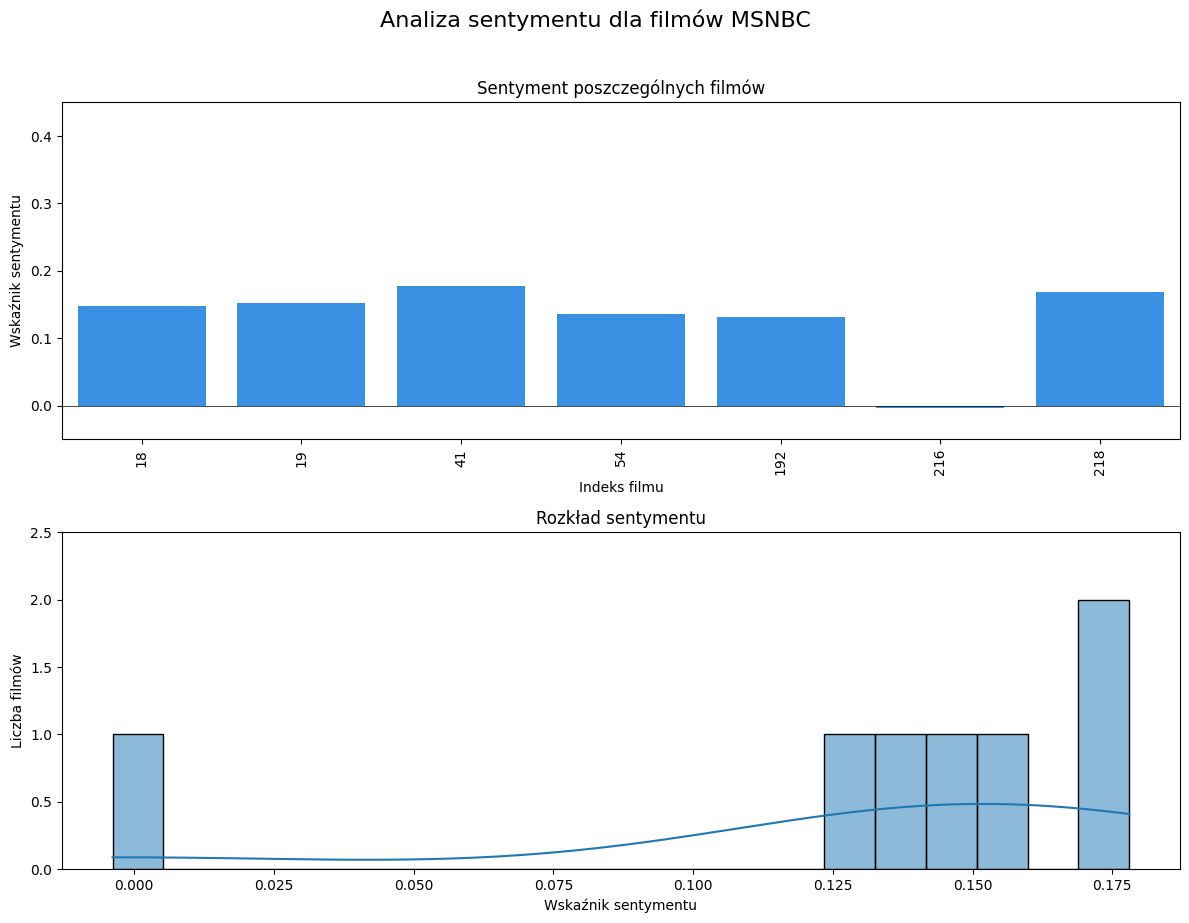

In [ ]:
sentiment_textblob3 = sentiment_data_channels_MSNBC.copy()
sentiment_textblob3["sentiment"] = sentiment_textblob3["text"].apply(sentiment_textblob_function)

plt.figure(figsize=(12, 9))

plt.subplot(2,1,1)
ax1 = sns.barplot(x=sentiment_textblob3.index, y="sentiment", data=sentiment_textblob3, color="dodgerblue")
plt.title("Sentyment poszczególnych filmów")
plt.xlabel("Indeks filmu")
plt.ylabel("Wskaźnik sentymentu")
plt.xticks(rotation = 90)
plt.ylim(-0.05, 0.45)
ax1.axhline(0, color='black', linestyle='-', linewidth=0.5)

plt.subplot(2,1,2)
sns.histplot(sentiment_textblob3["sentiment"], bins=20, kde = True)
plt.title('Rozkład sentymentu')
plt.xlabel('Wskaźnik sentymentu')
plt.ylabel('Liczba filmów')
plt.ylim(0, 2.5)

plt.suptitle('Analiza sentymentu dla filmów MSNBC', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


6/7 filmów MSNBC charakteryzuje się pozytywnymi wskaźnikami sentymentu, jeden film został oznaczony jako negatywny ale wynik jest bardzo zblizony do 0, a więc przyjrzyjmy się mu:

In [ ]:
print("Tytuł: ",data_cat.loc[216]['Tytuł'])
print("Liczba słow: ",data_cat.loc[216]['Liczba słów (po oczyszczeniu)'])
print("Tagi filmu:", data_cat.loc[216]['Tagi filmu'])
print("Długość filmu:", data_cat.loc[216]['Długość filmu'])

Tytuł:  Army Of Volunteers In Poland Welcome Ukrainian Refugees
Liczba słow:  381
Tagi filmu: ['Joe Scarborough', 'Willie Geist', 'Morning Joe', 'Mika Brzezinski', 'MSNBC', 'MSNBC news', 'MSNBC live', 'MSNBC TV', 'news', 'breaking news', 'current events', 'US news', 'politics', 'politics news', 'political news', 'elections', 'morning joe full', 'morning joe live', 'morning joe today', 'Ukraine', 'Ukraine invasion', 'Russia Ukraine crisis', 'Ukraine war', 'Ukraine refugees', 'Ukraine refugee crisis', 'Poland', 'Poland Ukraine refugees']
Długość filmu: 6


Tytuł filmu świadczy o pozytywnym nastawieniu do Polski, jednak na neagtywno/neutralny wynik mogą wpływać informacje na temat wojny na Ukrainie.: 

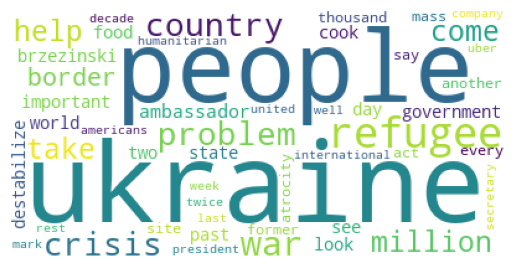

In [ ]:
wordcloud = WordCloud(background_color='white', max_words=50).generate(data_cat.loc[216]['Transkrypcja oczyszczona'])
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

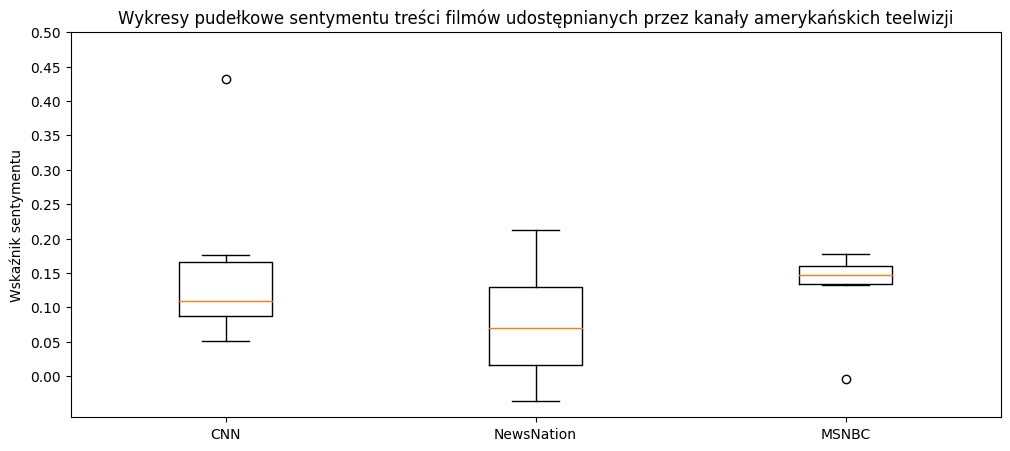

In [ ]:
plt.figure(figsize=(12, 5))

plt.boxplot([sentiment_textblob1["sentiment"], sentiment_textblob2["sentiment"], sentiment_textblob3["sentiment"]], labels=["CNN", "NewsNation", "MSNBC"])
plt.title("Wykresy pudełkowe sentymentu treści filmów udostępnianych przez kanały amerykańskich teelwizji")
plt.ylabel("Wskaźnik sentymentu")
plt.yticks([i/20 for i in range(11)])
plt.show()

Biorąc pod uwagę medianę, najpozytywniej w filmach powiązanych z Polską wypowiada się kanał stojący za stacją MSBNC. Ponadto kanał ten jest równiez najmniej zróznicowany pod kątem ogólnego wskaźnika sentymentu (najmniejszy rozstęp ćwiartkowy) ale zawiera jedną wartość odstającą ponizej mediany. Drugim najpozytywniej wypowiadającym się kanałem jest CNN, z jedną wartością odstającą nad medianą. Ostatnim kanałem w rankingu według metody boxplot jest NewsNation, o największym rozstępie ale bez wartości odstających. Zaden kanał nie charakteryzuje się negatywnym wskaźnikiem sentymentu.

Poniewaz CNN nie ma filmów o wyniku negatywnym, czego nie mozna powiedziec o MSNBC oraz CNN ma wartość odstającą nad medianą, a MSNBC pod, warto sprawdzić dodatkowo wyniki średniej:

In [ ]:
print("Średnia sentymentów dla CNN: ", round(sentiment_textblob1["sentiment"].mean(),3))
print("Średnia sentymentów dla NewsNation: ",round(sentiment_textblob2["sentiment"].mean(),3))
print("Średnia sentymentów dla MSNBC: ",round(sentiment_textblob3["sentiment"].mean(),3))

Średnia sentymentów dla CNN:  0.149
Średnia sentymentów dla NewsNation:  0.08
Średnia sentymentów dla MSNBC:  0.13


Ranking pod względem średniej jest następujący: CNN, MSNBC, NewsNation

<hr>

Biorąc pod uwagę wykresy ukazujące sentyment dla kazdego filmu (oraz wniosek, ze film oznaczony jako negatywno/neutralny moze być błędny), ranking na podstawie boxplotów oraz ranking na podstawie średniej mozna stwierdzić, ze najpozytywniej wypowiadają się (po równo) kanały, za którymi stoją stacje telewizyjne CNN oraz MSNBC . Trochę gorzej lecz wciąz ogólnie rzecz biorąc pozytywnie kreuje treści swoich filmów związanych z tematyką Polski kanał NewsNation. Faktem jest, ze wszystkie kanały charakteryzują się ogólną pozytywną treścia, jednakze mediany i średnie nie przekraczają wyniku 0.15, co jest dosyć niską wartością.

Wiarygodność wyników podnosi fakt, ze wszytskie kanały udostępniły bardzo podobną/identyczą liczbe filmów (8, 8 i 7). Jednak nalezy zwrócić uwagę, ze jest to dosyć mały zbiór. 

<hr>